In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import timedelta
import numpy as np

In [2]:
!pip freeze > requirements.txt

In [3]:
# Get the versions for the paper
import matplotlib
import numpy
import pandas
import seaborn

print("matplotlib==", matplotlib.__version__)
print("numpy==", numpy.__version__)
print("pandas==", pandas.__version__)
print("seaborn==", seaborn.__version__)


matplotlib== 3.10.3
numpy== 2.2.6
pandas== 2.2.3
seaborn== 0.13.2


In [4]:
# Load the dataset
df = pd.read_csv("dataset.csv", parse_dates=['date'])


In [5]:
#rename the first un named column to record_id
df.rename(columns={"Unnamed: 0": "record_id"}, inplace=True)

In [6]:
df.head()

,record_id,location_variance,location_entropy,normalized_location_entropy,distance_traveled,home_stay,num_cluster,total_cluster_stay,home_stay_proportion,max_pairwise_distance,...,totcorrect_df_z,dig_forward_tc_zscore,totcorrect_db_z,br_longestdigb_z,an_z_score,craft_delay_verb_z,craft_delay_para_z,ant_z_score,vsat_total_time_z,vsat_total_errors_z
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.01,-1.28,-1.05,-0.91,1.48,-0.49,0.06,-0.01,46.1,53.3
1,1,-6.573652,0.538630,0.490282,78.522110,17.646453,3.0,21.198072,0.832456,9.409711,...,-1.01,-1.28,-1.05,-0.91,1.48,-0.49,0.06,-0.01,46.1,53.3
2,2,-6.917439,0.688375,0.427711,66.358800,16.460424,5.0,20.268571,0.812116,12.594788,...,-1.01,-1.28,-1.05,-0.91,1.48,-0.49,0.06,-0.01,46.1,53.3
3,3,NaN,NaN,NaN,46.418207,NaN,NaN,NaN,NaN,NaN,...,-1.01,-1.28,-1.05,-0.91,1.48,-0.49,0.06,-0.01,46.1,53.3
4,4,-9.792112,0.263898,0.240211,11.035439,14.137492,3.0,15.046391,0.939594,3.790653,...,-1.01,-1.28,-1.05,-0.91,1.48,-0.49,0.06,-0.01,46.1,53.3


#Demographics

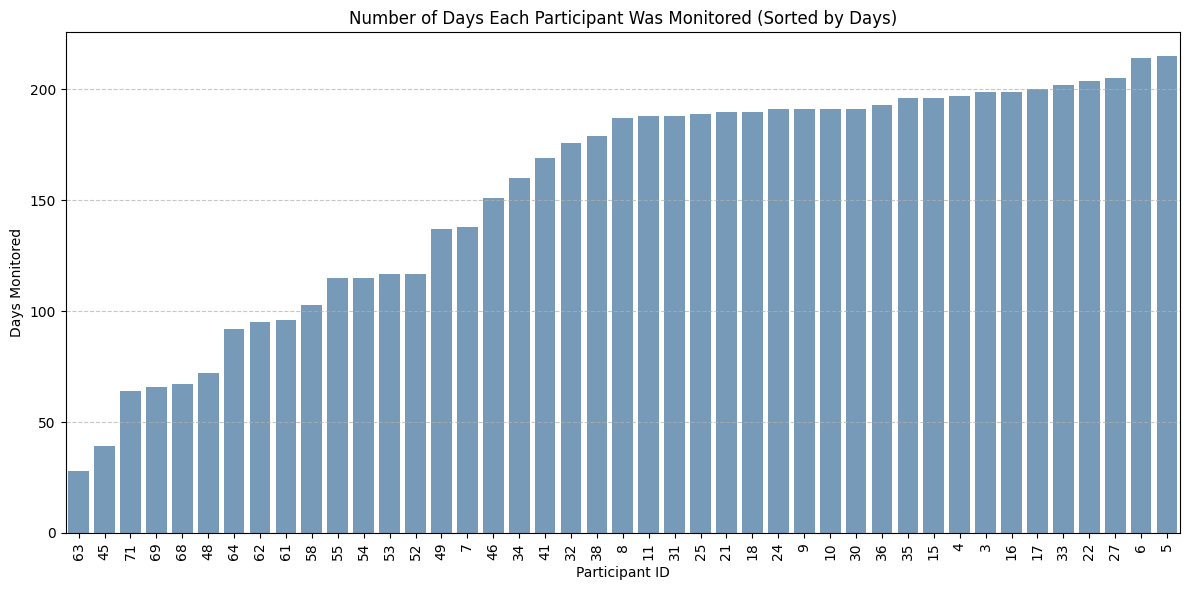

In [7]:
# 1. Number of days monitored
# Count how many unique dates each participant was monitored
participant_days_monitored = df.groupby('participant_id')['date'].nunique().reset_index()
participant_days_monitored.columns = ['participant_id', 'days_monitored']
# Sort the data in ascending order by days_monitored and convert participant_id to string for better label readability
participant_days_monitored_sorted = participant_days_monitored.sort_values(by='days_monitored')
participant_days_monitored_sorted['participant_id'] = participant_days_monitored_sorted['participant_id'].astype(str)

# Plotting the sorted data by number of days
plt.figure(figsize=(12, 6))
sns.barplot(data=participant_days_monitored_sorted, x='participant_id', y='days_monitored', color='steelblue',alpha=0.8)
plt.title("Number of Days Each Participant Was Monitored (Sorted by Days)")
plt.xlabel("Participant ID")
plt.ylabel("Days Monitored")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

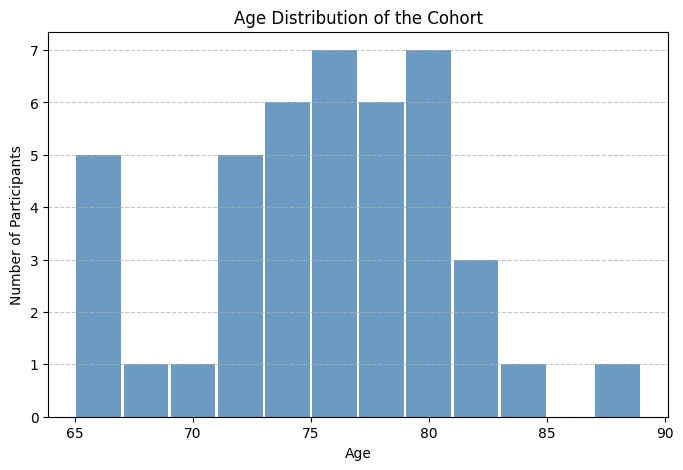

In [8]:
# 2. Age distribution
# Group by participant_id and get the first age entry for each participant
age_df = df.groupby("participant_id", as_index=False)["age"].first()

# Create bins for age
bins = np.arange(age_df["age"].min(), age_df["age"].max() + 2, 2)  # step of 2 years

# Get counts per bin
counts, bin_edges = np.histogram(age_df["age"], bins=bins)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot bar chart with steelblue color
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, counts, width=1.9, color="steelblue",alpha=0.8)
plt.xlabel("Age")
plt.ylabel("Number of Participants")
plt.title("Age Distribution of the Cohort")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

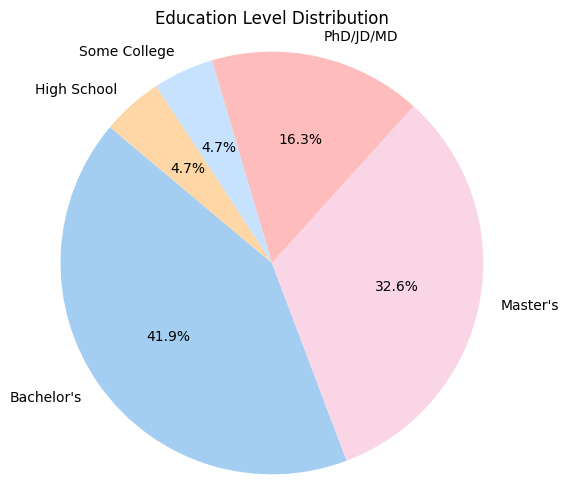

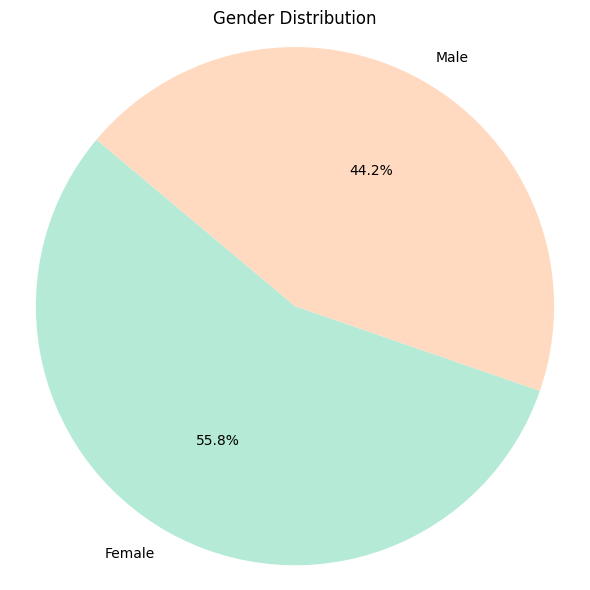

In [9]:
# Education and Gender Distribution
# Group by participant_id to get unique entries per participant
participants_df = df.groupby('participant_id').agg({
    'sex': 'first',
    'age': 'first',
    'education': 'first'
}).reset_index()

# Define custom pastel color palettes for both charts
education_colors = ['#A3CEF1', '#F9D5E5', '#FFBCBC', '#C6E2FF', '#FFD6A5']
gender_colors = ['#B5EAD7', '#FFDAC1']

# Education pie chart
edu_counts = participants_df['education'].map({
    12: 'High School',
    15: 'Some College',
    16: 'Bachelor\'s',
    18: 'Master\'s',
    20: 'PhD/JD/MD'
}).value_counts()

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(edu_counts.values, labels=edu_counts.index, autopct='%1.1f%%', startangle=140, colors=education_colors)
ax1.set_title('Education Level Distribution')
ax1.axis('equal')

# Gender pie chart
gender_counts = participants_df['sex'].map({0: 'Male', 1: 'Female'}).value_counts()

fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=gender_colors)
ax2.set_title('Gender Distribution')
ax2.axis('equal')

plt.tight_layout()
plt.show()


#GPS

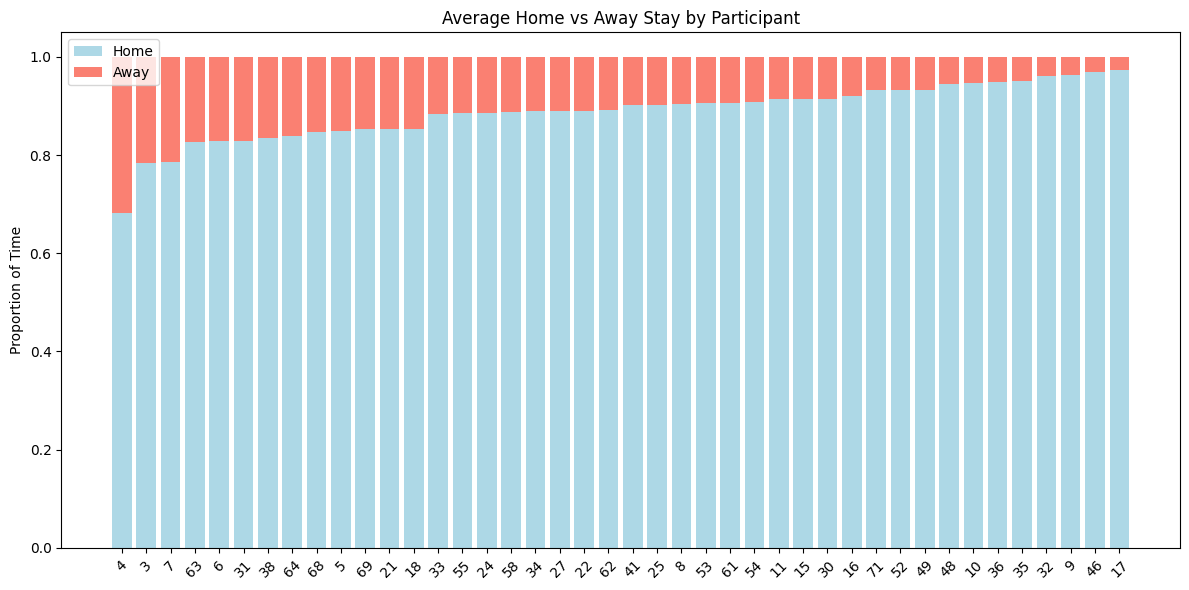

In [10]:
#1. GPS plot

gps_columns = [
    'participant_id',
    'home_stay_proportion'
]
gps_data = df[gps_columns].dropna(subset=['home_stay_proportion'])

# Calculate average home and away time proportions for each participant
gps_home_away = gps_data[['participant_id', 'home_stay_proportion']].copy()
gps_home_away['away_stay_proportion'] = 1 - gps_home_away['home_stay_proportion']
gps_home_away = gps_home_away.groupby('participant_id').mean()

# Plot a stacked bar chart for home vs away stay
plt.figure(figsize=(12, 6))
gps_home_away.sort_values('home_stay_proportion', inplace=True)
plt.bar(gps_home_away.index.astype(str), gps_home_away['home_stay_proportion'], label='Home', color='lightblue')
plt.bar(gps_home_away.index.astype(str), gps_home_away['away_stay_proportion'], bottom=gps_home_away['home_stay_proportion'], label='Away', color='salmon')
plt.xticks(rotation=45)
plt.ylabel('Proportion of Time')
plt.title('Average Home vs Away Stay by Participant')
plt.legend()
plt.tight_layout()
plt.show()


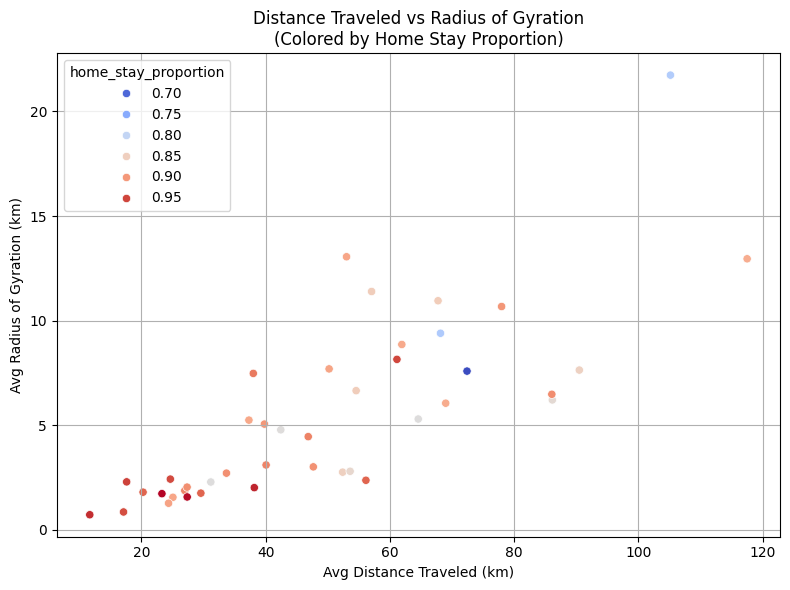

In [11]:
#2.GPS plot
# Filter relevant GPS columns and remove rows with missing values in those columns
gps_df = df[[
    'participant_id', 'date', 'distance_traveled', 'radius_of_gyration',
    'home_stay_proportion', 'moving_time'
]].dropna()

# Convert date column to datetime
gps_df['date'] = pd.to_datetime(gps_df['date'])

# Aggregate per participant by averaging values
agg_df = gps_df.groupby('participant_id').agg({
    'distance_traveled': 'mean',
    'radius_of_gyration': 'mean',
    'home_stay_proportion': 'mean',
    'moving_time': 'mean'
}).reset_index()

# Distance Traveled vs Radius of Gyration
plt.figure(figsize=(8, 6))
sns.scatterplot(data=agg_df, x='distance_traveled', y='radius_of_gyration', hue='home_stay_proportion', palette='coolwarm')
plt.title('Distance Traveled vs Radius of Gyration\n(Colored by Home Stay Proportion)')
plt.xlabel('Avg Distance Traveled (km)')
plt.ylabel('Avg Radius of Gyration (km)')
plt.tight_layout()
plt.grid(True)
plt.show()

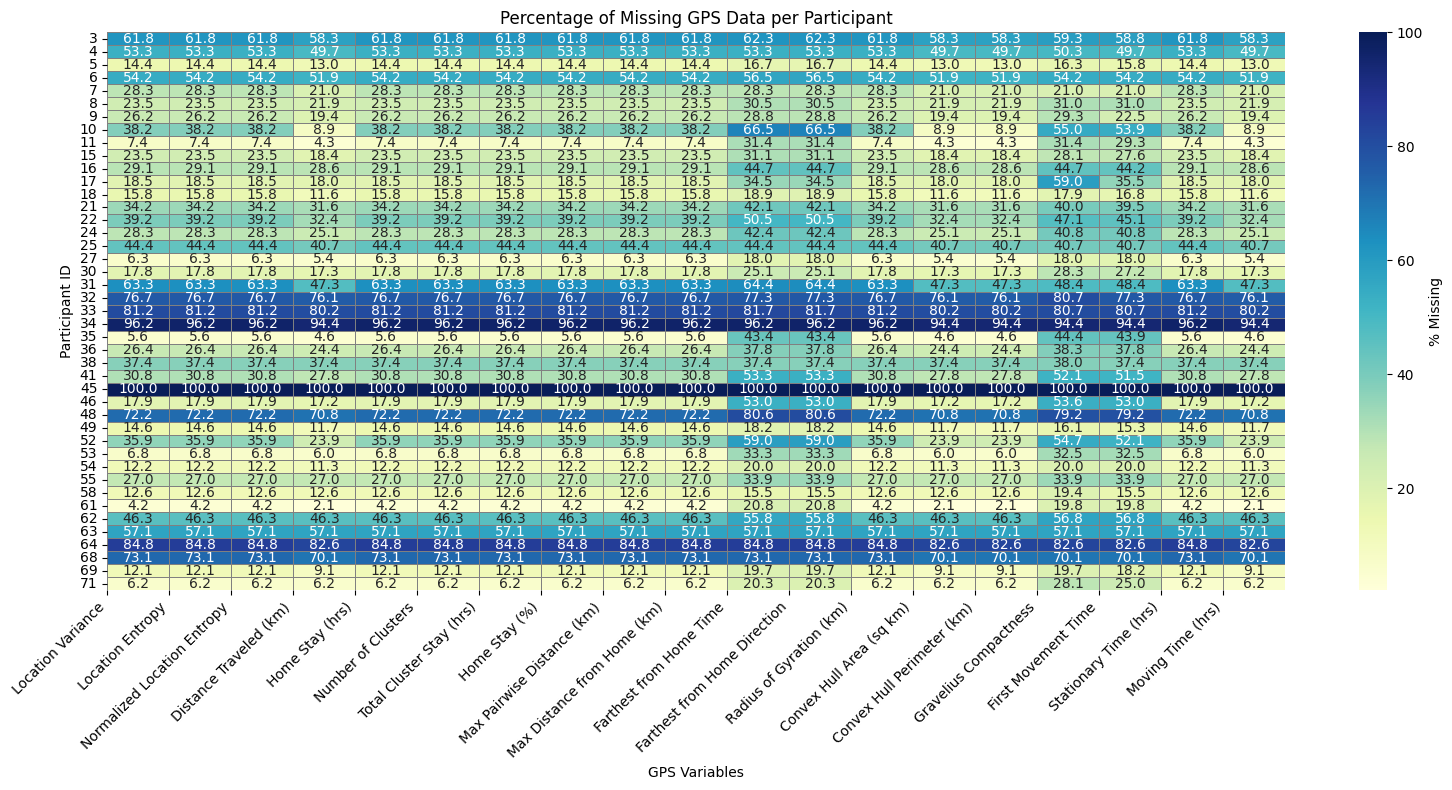

In [12]:
#3 gps plot
# List of GPS columns
gps_columns = [
    "location_variance", "location_entropy", "normalized_location_entropy",
    "distance_traveled", "home_stay", "num_cluster", "total_cluster_stay",
    "home_stay_proportion", "max_pairwise_distance", "max_distance_from_home",
    "farthest_from_home_time", "farthest_from_home_dir", "radius_of_gyration",
    "convex_hull_area", "convex_hull_perimeter", "gravelius_compactness",
    "first_movement_time", "stationary_time", "moving_time"
]

# Mapping of GPS variable names to human-readable labels
gps_labels = {
    "location_variance": "Location Variance",
    "location_entropy": "Location Entropy",
    "normalized_location_entropy": "Normalized Location Entropy",
    "distance_traveled": "Distance Traveled (km)",
    "home_stay": "Home Stay (hrs)",
    "num_cluster": "Number of Clusters",
    "total_cluster_stay": "Total Cluster Stay (hrs)",
    "home_stay_proportion": "Home Stay (%)",
    "max_pairwise_distance": "Max Pairwise Distance (km)",
    "max_distance_from_home": "Max Distance from Home (km)",
    "farthest_from_home_time": "Farthest from Home Time",
    "farthest_from_home_dir": "Farthest from Home Direction",
    "radius_of_gyration": "Radius of Gyration (km)",
    "convex_hull_area": "Convex Hull Area (sq km)",
    "convex_hull_perimeter": "Convex Hull Perimeter (km)",
    "gravelius_compactness": "Gravelius Compactness",
    "first_movement_time": "First Movement Time",
    "stationary_time": "Stationary Time (hrs)",
    "moving_time": "Moving Time (hrs)"
}

# Calculate % missing for each participant for GPS variables
gps_missing = df.groupby("participant_id")[gps_columns].apply(lambda x: x.isna().mean() * 100)

# Apply the human-readable labels for x-axis
display_labels = [gps_labels.get(col, col) for col in gps_columns]

# Plot heatmap with percentage annotations
plt.figure(figsize=(16, 8))
sns.heatmap(
    gps_missing, 
    cmap="YlGnBu", 
    linewidths=0.5, 
    linecolor='gray', 
    annot=True, 
    fmt=".1f", 
    cbar_kws={'label': '% Missing'}
)
plt.title("Percentage of Missing GPS Data per Participant")
plt.xlabel("GPS Variables")
plt.ylabel("Participant ID")
plt.xticks(ticks=range(len(display_labels)), labels=display_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Digital Behaviour

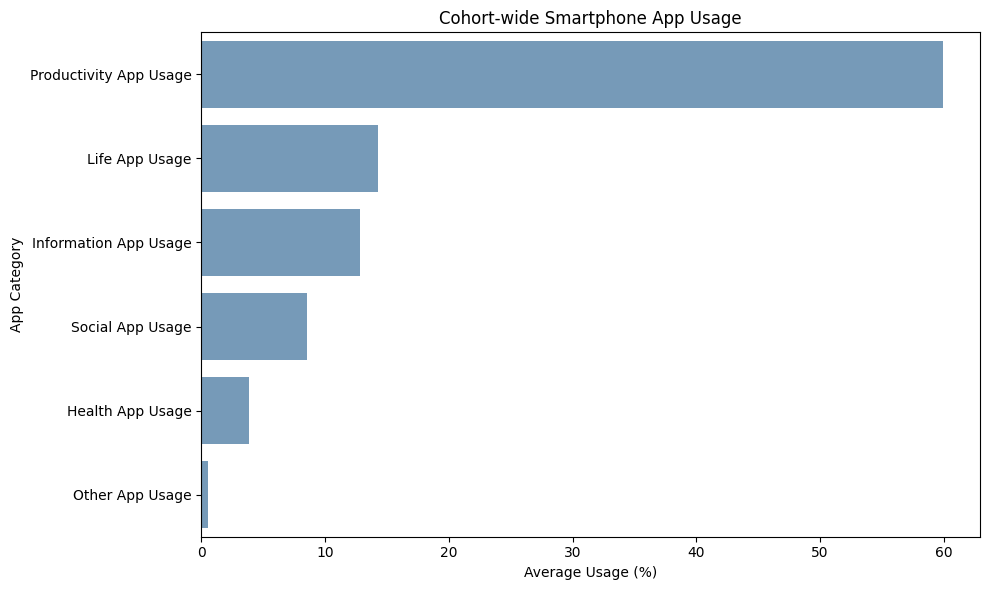

In [13]:
#1. Db plot

# list required columns
app_columns = [
    'information_app_usage_proportion',
    'productivity_app_usage_proportion',
    'life_app_usage_proportion',
    'health_app_usage_proportion',
    'social_app_usage_proportion',
    'other_app_usage_proportion'
]

# Prepare data sorted by ascending average usage
app_data = df[app_columns].mean().sort_values(ascending=False)
app_labels_sorted = app_data.index
app_percentages_sorted = app_data.values * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=app_percentages_sorted, y=app_labels_sorted.str.replace('_proportion', '').str.replace('_', ' ').str.title(), color="steelblue",alpha=0.8)
plt.xlabel("Average Usage (%)")
plt.ylabel("App Category")
plt.title("Cohort-wide Smartphone App Usage")
plt.tight_layout()
plt.show()

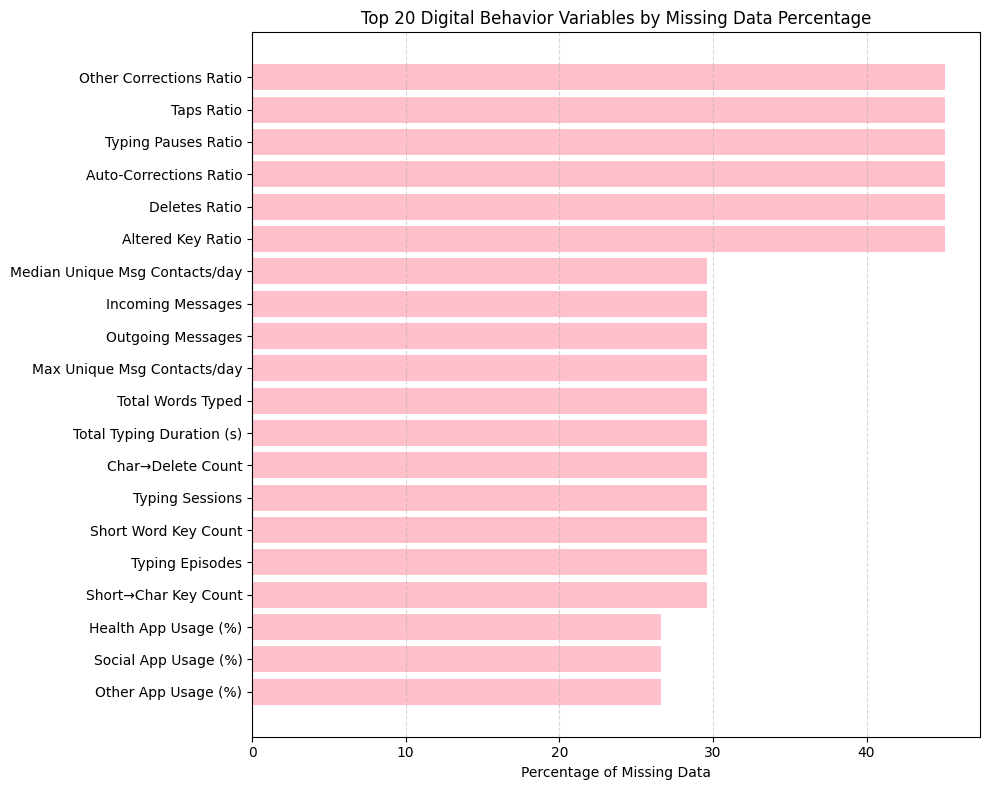

In [14]:
#2. Db plot

# Digital Behavior variables (raw only, no calculated fields)
digital_behavior_vars = [
    'total_unlocks',
    'total_unlock_duration',
    'information_app_usage_proportion',
    'productivity_app_usage_proportion',
    'life_app_usage_proportion',
    'health_app_usage_proportion',
    'social_app_usage_proportion',
    'other_app_usage_proportion',
    'total_typing_sessions',
    'total_words',
    'taps_ratio',
    'altered_ratio',
    'deletes_ratio',
    'auto_corrections_ratio',
    'other_corrections_ratio',
    'pauses_ratio',
    'total_typing_duration',
    'total_typing_episodes',
    'shortWordCharKey_count',
    'shortWordCharKeyToCharKey_count',
    'charKeyToDelete_count',
    'incoming_call',
    'outgoing_call',
    'call_duration',
    'call_unique_contacts',
    'outgoing_msg',
    'incoming_msg',
    'msg_unique_contacts_day_median',
    'msg_unique_contacts_day_max'
]

# Mapping of raw variable names to human-readable labels
var_labels = {
    'total_unlocks': 'Total Unlocks',
    'total_unlock_duration': 'Total Unlock Duration (min)',
    'information_app_usage_proportion': 'Information App Usage (%)',
    'productivity_app_usage_proportion': 'Productivity App Usage (%)',
    'life_app_usage_proportion': 'Life App Usage (%)',
    'health_app_usage_proportion': 'Health App Usage (%)',
    'social_app_usage_proportion': 'Social App Usage (%)',
    'other_app_usage_proportion': 'Other App Usage (%)',
    'total_typing_sessions': 'Typing Sessions',
    'total_words': 'Total Words Typed',
    'taps_ratio': 'Taps Ratio',
    'altered_ratio': 'Altered Key Ratio',
    'deletes_ratio': 'Deletes Ratio',
    'auto_corrections_ratio': 'Auto-Corrections Ratio',
    'other_corrections_ratio': 'Other Corrections Ratio',
    'pauses_ratio': 'Typing Pauses Ratio',
    'total_typing_duration': 'Total Typing Duration (s)',
    'total_typing_episodes': 'Typing Episodes',
    'shortWordCharKey_count': 'Short Word Key Count',
    'shortWordCharKeyToCharKey_count': 'Short→Char Key Count',
    'charKeyToDelete_count': 'Char→Delete Count',
    'incoming_call': 'Incoming Calls',
    'outgoing_call': 'Outgoing Calls',
    'call_duration': 'Total Call Duration (min)',
    'call_unique_contacts': 'Unique Call Contacts',
    'outgoing_msg': 'Outgoing Messages',
    'incoming_msg': 'Incoming Messages',
    'msg_unique_contacts_day_median': 'Median Unique Msg Contacts/day',
    'msg_unique_contacts_day_max': 'Max Unique Msg Contacts/day'
}


# Calculate missing percentages
missing_percentage = df[digital_behavior_vars].isnull().mean() * 100
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# Replace variable names with human-readable labels
display_labels = [
    var_labels.get(var, var)
    for var in missing_percentage_sorted.head(20).index
]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(display_labels, missing_percentage_sorted.head(20), color='pink')
plt.xlabel('Percentage of Missing Data')
plt.title('Top 20 Digital Behavior Variables by Missing Data Percentage')
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


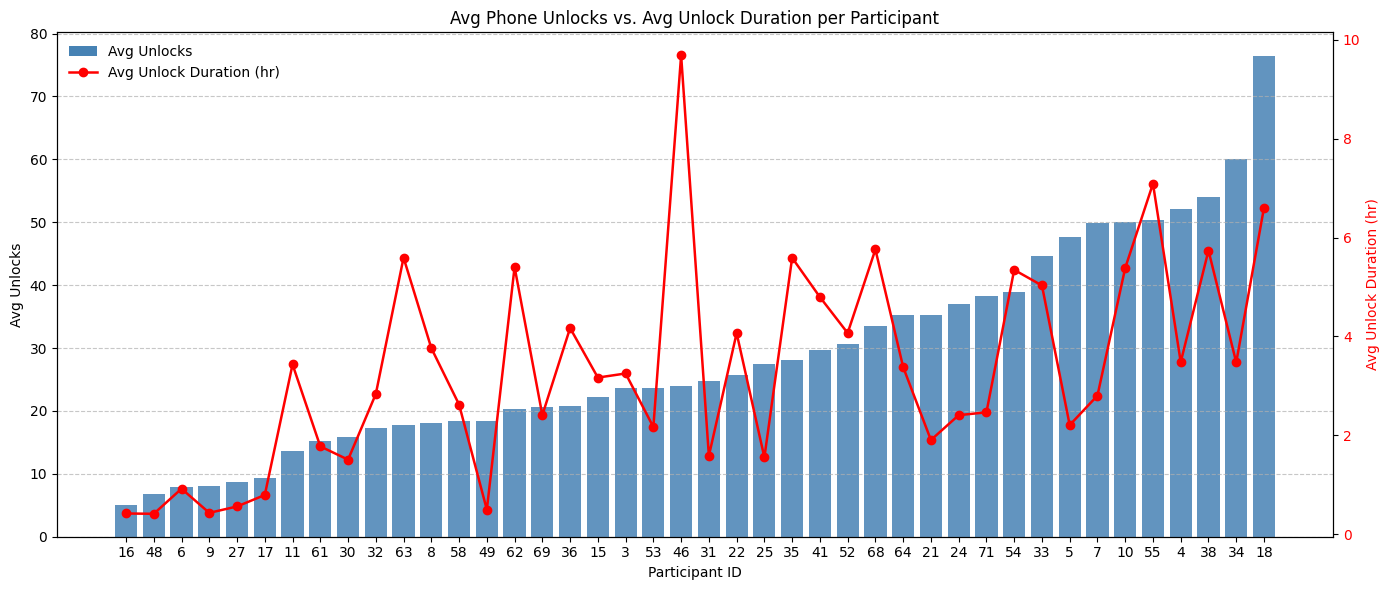

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# prep
df_unlock = df[['participant_id', 'total_unlocks', 'total_unlock_duration']].dropna().copy()
df_unlock['total_unlock_duration_hr'] = df_unlock['total_unlock_duration'] / 3600

grouped = (df_unlock
           .groupby('participant_id', as_index=False)
           .agg(total_unlocks=('total_unlocks','mean'),
                total_unlock_duration_hr=('total_unlock_duration_hr','mean')))

grouped_sorted = grouped.sort_values(by='total_unlocks')

# plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# bars: avg unlocks
bars = ax1.bar(
    grouped_sorted['participant_id'].astype(str),
    grouped_sorted['total_unlocks'],
    color='steelblue',  # blue
    alpha=0.85
)
ax1.set_xlabel('Participant ID')
ax1.set_ylabel('Avg Unlocks', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# line: avg unlock duration (hr) on secondary axis
ax2 = ax1.twinx()
line, = ax2.plot(
    grouped_sorted['participant_id'].astype(str),
    grouped_sorted['total_unlock_duration_hr'],
    color='red',
    marker='o',
    linewidth=1.8
)
ax2.set_ylabel('Avg Unlock Duration (hr)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Avg Phone Unlocks vs. Avg Unlock Duration per Participant')
plt.xticks(rotation=90)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# custom legend (blue bar + red line)
legend_handles = [
    Patch(facecolor='steelblue', edgecolor='none', label='Avg Unlocks'),
    Line2D([0], [0], color='red', marker='o', linewidth=1.8, label='Avg Unlock Duration (hr)')
]
ax1.legend(handles=legend_handles, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


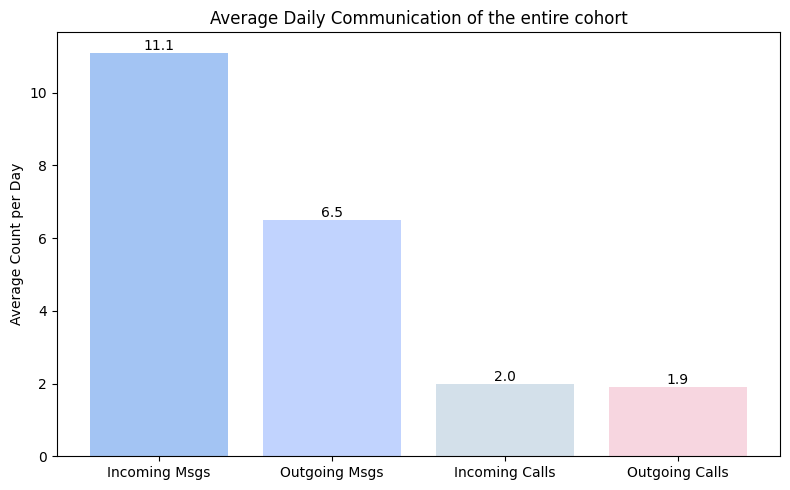

In [16]:
# 4 Db plot

# Data
categories = ['Incoming Msgs', 'Outgoing Msgs', 'Incoming Calls', 'Outgoing Calls']
values = [11.1, 6.5, 2.0, 1.9]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values, color=['#a3c4f3', '#c1d3fe', '#d3e0ea', '#f7d6e0'])
plt.title('Average Daily Communication of the entire cohort')
plt.ylabel('Average Count per Day')

# Adding value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Motor Visualizations



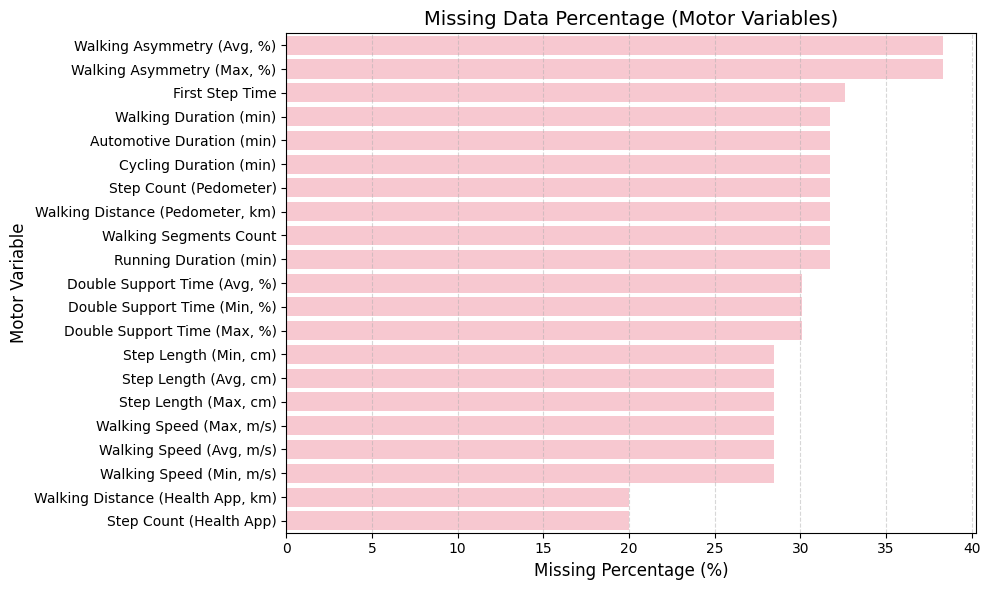

In [17]:
# 1 Motor viz

# List of motor variables
motor_vars = [
    'walking_duration', 'running_duration', 'automotive_duration', 'cycling_duration', 'step_count_pedo',
    'walking_distance_pedo', 'walking_segments_count', 'first_step_time', 'step_count_health',
    'walking_distance_health', 'walking_speed_min', 'walking_speed_avg', 'walking_speed_max',
    'walking_step_length_min', 'walking_step_length_avg', 'walking_step_length_max',
    'walking_asymmetry_avg', 'walking_asymmetry_max', 'double_support_time_min',
    'double_support_time_avg', 'double_support_time_max'
]

# Mapping for human-readable labels
motor_labels = {
    'walking_duration': 'Walking Duration (min)',
    'running_duration': 'Running Duration (min)',
    'automotive_duration': 'Automotive Duration (min)',
    'cycling_duration': 'Cycling Duration (min)',
    'step_count_pedo': 'Step Count (Pedometer)',
    'walking_distance_pedo': 'Walking Distance (Pedometer, km)',
    'walking_segments_count': 'Walking Segments Count',
    'first_step_time': 'First Step Time',
    'step_count_health': 'Step Count (Health App)',
    'walking_distance_health': 'Walking Distance (Health App, km)',
    'walking_speed_min': 'Walking Speed (Min, m/s)',
    'walking_speed_avg': 'Walking Speed (Avg, m/s)',
    'walking_speed_max': 'Walking Speed (Max, m/s)',
    'walking_step_length_min': 'Step Length (Min, cm)',
    'walking_step_length_avg': 'Step Length (Avg, cm)',
    'walking_step_length_max': 'Step Length (Max, cm)',
    'walking_asymmetry_avg': 'Walking Asymmetry (Avg, %)',
    'walking_asymmetry_max': 'Walking Asymmetry (Max, %)',
    'double_support_time_min': 'Double Support Time (Min, %)',
    'double_support_time_avg': 'Double Support Time (Avg, %)',
    'double_support_time_max': 'Double Support Time (Max, %)'
}

# Calculate missing percentage for selected motor variables
missing_percent = df[motor_vars].isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

# Replace variable names with human-readable labels
display_labels = [motor_labels.get(var, var) for var in missing_percent.index]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.values, y=display_labels, color="pink")
plt.xlabel("Missing Percentage (%)", fontsize=12)
plt.ylabel("Motor Variable", fontsize=12)
plt.title("Missing Data Percentage (Motor Variables)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


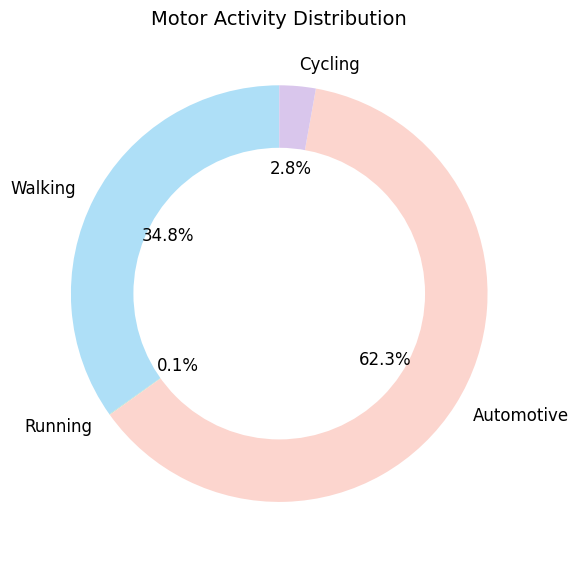

In [18]:
# 2 motor Viz

# Relevant motor activity columns
activity_cols = [
    "walking_duration",
    "running_duration",
    "automotive_duration",
    "cycling_duration"
]

# Convert durations from hours to minutes and compute mean for each activity
activity_means_min = df[activity_cols].mean(skipna=True) * 60  # converting hours to minutes

# Prepare the data for the donut chart
labels = ["Walking", "Running", "Automotive", "Cycling"]
sizes = activity_means_min.values
colors = ['#AEDFF7', '#B0E3CC', '#FCD5CE', '#D9C6EC']  # soft clinical colors

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
# Draw circle in center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Set title
plt.title("Motor Activity Distribution", fontsize=14)
plt.tight_layout()
plt.show()

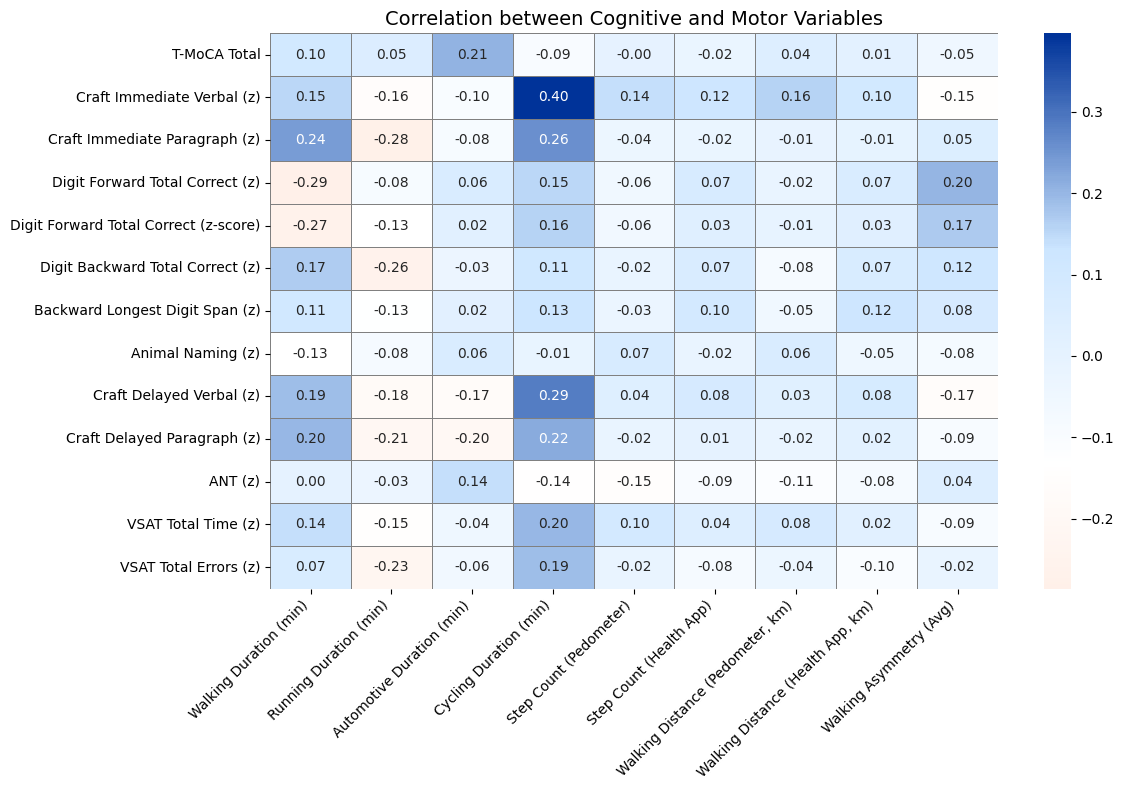

In [19]:
# 3 motor viz

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#  Mapping the variable to human readable names
cognitive_labels = {
    "tmoca_rater_total": "T-MoCA Total",
    "craft_im_verb_z": "Craft Immediate Verbal (z)",
    "craft_im_para_z": "Craft Immediate Paragraph (z)",
    "totcorrect_df_z": "Digit Forward Total Correct (z)",
    "dig_forward_tc_zscore": "Digit Forward Total Correct (z-score)",
    "totcorrect_db_z": "Digit Backward Total Correct (z)",
    "br_longestdigb_z": "Backward Longest Digit Span (z)",
    "an_z_score": "Animal Naming (z)",
    "craft_delay_verb_z": "Craft Delayed Verbal (z)",
    "craft_delay_para_z": "Craft Delayed Paragraph (z)",
    "ant_z_score": "ANT (z)",
    "vsat_total_time_z": "VSAT Total Time (z)",
    "vsat_total_errors_z": "VSAT Total Errors (z)",
}

motor_labels = {
    "walking_duration": "Walking Duration (min)",
    "running_duration": "Running Duration (min)",
    "automotive_duration": "Automotive Duration (min)",
    "cycling_duration": "Cycling Duration (min)",
    "step_count_pedo": "Step Count (Pedometer)",
    "step_count_health": "Step Count (Health App)",
    "walking_distance_pedo": "Walking Distance (Pedometer, km)",
    "walking_distance_health": "Walking Distance (Health App, km)",
    "walking_asymmetry_avg": "Walking Asymmetry (Avg)"
}

# original variable lists
cognitive_vars = [
    "tmoca_rater_total", "craft_im_verb_z", "craft_im_para_z", "totcorrect_df_z",
    "dig_forward_tc_zscore", "totcorrect_db_z", "br_longestdigb_z", "an_z_score",
    "craft_delay_verb_z", "craft_delay_para_z", "ant_z_score", "vsat_total_time_z",
    "vsat_total_errors_z"
]

motor_vars = [
    "walking_duration", "running_duration", "automotive_duration", "cycling_duration",
    "step_count_pedo", "step_count_health", "walking_distance_pedo", "walking_distance_health", "walking_asymmetry_avg"
]

# Filter, group, and compute correlations
selected_vars = ["participant_id"] + cognitive_vars + motor_vars
df_selected = df[selected_vars].dropna()
df_grouped = df_selected.groupby("participant_id").mean(numeric_only=True).reset_index()

correlation_matrix = (
    df_grouped[cognitive_vars + motor_vars]
    .corr()
    .loc[cognitive_vars, motor_vars]
)

# Rename axes to human readable labels
corr_labeled = correlation_matrix.rename(
    index=cognitive_labels, columns=motor_labels
)

# Custom diverging colormap
colors = [
    (1.0, 0.90, 0.85),  # light peach (negative)
    (1.0, 1.0, 1.0),    # white at 0
    (0.80, 0.90, 1.0),  # light blue (low positive)
    (0.00, 0.20, 0.60)  # dark blue (high positive)
]
custom_cmap = LinearSegmentedColormap.from_list("peach_to_blue", colors, N=256)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_labeled,
    annot=True, fmt=".2f",
    cmap=custom_cmap, center=0,   # center at 0 for diverging colors
    linewidths=0.5, linecolor="gray",
    cbar=True
)

plt.title("Correlation between Cognitive and Motor Variables", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Cognitive

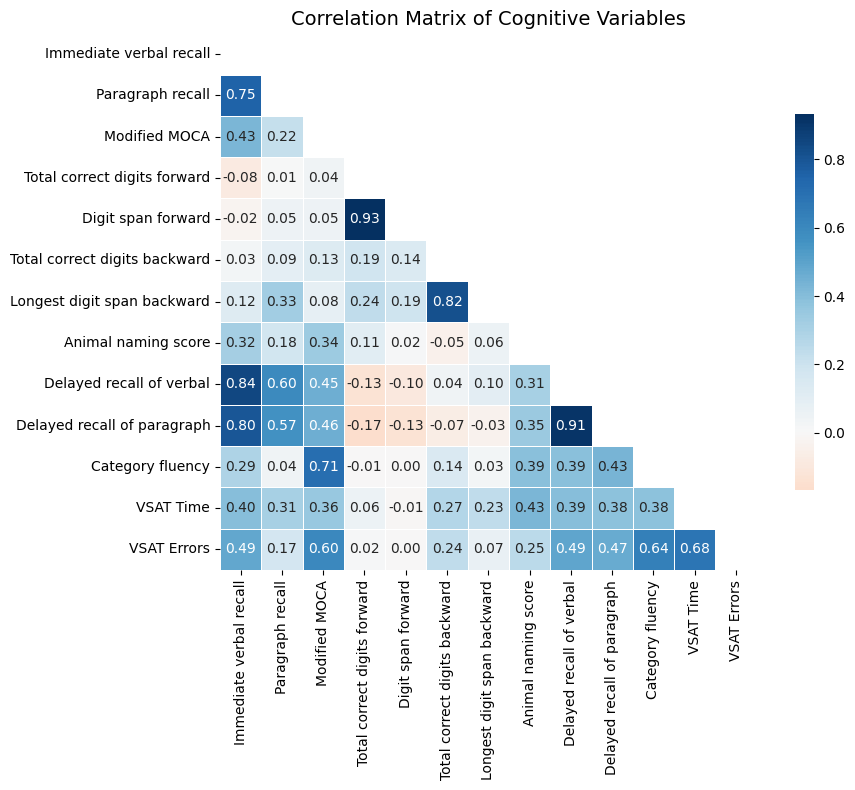

In [20]:
# 1 cognitive Viz

df["true_vsat_time_z"] = (df["vsat_total_time_z"] - 50) / 10
df["true_vsat_errors_z"] = (df["vsat_total_errors_z"] - 50) / 10

# Define mapping for cognitive variable labels
cognitive_labels = {
    "craft_im_verb_z": "Immediate verbal recall",
    "craft_im_para_z": "Paragraph recall",
    "tmoca_rater_total": "Modified MOCA",
    "totcorrect_df_z": "Total correct digits forward",
    "dig_forward_tc_zscore": "Digit span forward",
    "totcorrect_db_z": "Total correct digits backward",
    "br_longestdigb_z": "Longest digit span backward",
    "an_z_score": "Animal naming score",
    "craft_delay_verb_z": "Delayed recall of verbal",
    "craft_delay_para_z": "Delayed recall of paragraph",
    "ant_z_score": "Category fluency",
    "true_vsat_time_z": "VSAT Time",
    "true_vsat_errors_z": "VSAT Errors",
}

# Define cognitive variables
cognitive_vars = [
    "craft_im_verb_z", "craft_im_para_z", "tmoca_rater_total", "totcorrect_df_z",
    "dig_forward_tc_zscore", "totcorrect_db_z", "br_longestdigb_z", "an_z_score",
    "craft_delay_verb_z", "craft_delay_para_z", "ant_z_score",
    "true_vsat_time_z", "true_vsat_errors_z"
]

# Subset the data
df_cog = df[cognitive_vars]

# Compute correlation matrix
corr = df_cog.corr()

# Rename rows and columns of the matrix to meaningful labels
corr_labeled = corr.rename(index=cognitive_labels, columns=cognitive_labels)

# Generate mask for upper triangle
mask = np.triu(np.ones_like(corr_labeled, dtype=bool))

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_labeled,
    mask=mask,
    cmap='RdBu',
    center=0,
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.7},
    ax=ax
)
plt.title("Correlation Matrix of Cognitive Variables", fontsize=14)
plt.tight_layout()
plt.show()


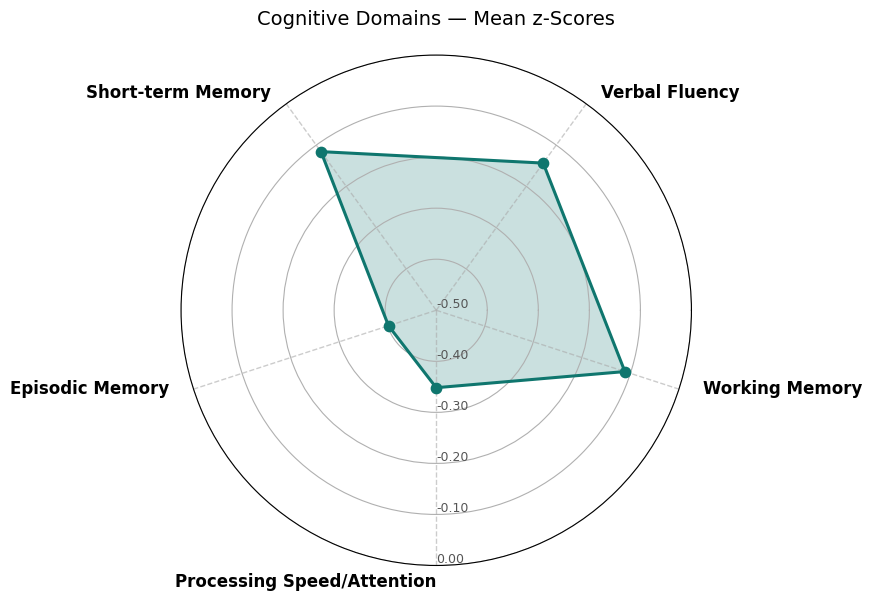

In [21]:
# 2 cognitive plot 
# convert columns to z values
# VSAT true z
if "vsat_total_time_z" in df.columns:
    df["true_vsat_time_z"] = (df["vsat_total_time_z"] - 50) / 10
if "vsat_total_errors_z" in df.columns:
    df["true_vsat_errors_z"] = (df["vsat_total_errors_z"] - 50) / 10


# Domain variables (overlaps allowed)

domains_map = {
    "Episodic Memory": [
        "craft_im_verb_z", "craft_im_para_z",
        "craft_delay_verb_z", "craft_delay_para_z",
    ],
    "Verbal Fluency": [
        "an_z_score", "ant_z_score",
    ],
    "Processing Speed/Attention": [
        "true_vsat_time_z", "true_vsat_errors_z",
    ],
    "Working Memory": [
        "totcorrect_db_z", "br_longestdigb_z",
        "totcorrect_df_z", "dig_forward_tc_zscore",
    ],
    "Short-term Memory": [
        "totcorrect_df_z", "dig_forward_tc_zscore",
    ],
}

# keep only columns that exist in df
domains_map = {d: [c for c in cols if c in df.columns] for d, cols in domains_map.items()}


# domain means
domain_means = {}
for dom, cols in domains_map.items():
    if len(cols) == 0:
        domain_means[dom] = np.nan
    else:
        # mean of per-variable means (equivalent to df[cols].mean(axis=0).mean())
        domain_means[dom] = float(df[cols].mean(skipna=True).mean())

# Arrange around the compass (North first)
ordered_labels = [
    "Processing Speed/Attention",
    "Working Memory",
    "Verbal Fluency",
    "Short-term Memory",
    "Episodic Memory",
]
values = [0.0 if pd.isna(domain_means.get(k, np.nan)) else domain_means[k]
          for k in ordered_labels]

# close the polygon
angles = np.linspace(0, 2*np.pi, len(ordered_labels), endpoint=False)
angles = (np.pi/2) - angles              # put first axis at North
angles = (angles + 2*np.pi) % (2*np.pi)  # normalize to [0, 2π)
angles_closed = np.append(angles, angles[0])
values_closed = values + [values[0]]

# Plot (rticks placed at actual domain means)
# radial limits & ticks based on the data
mean_values = values
rmin, rmax = -0.5, 0
rticks = [-0.5,-0.4, -0.3, -0.2, -0.1, 0]

plt.figure(figsize=(8.5, 6.5))
ax = plt.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_rlim(rmin, rmax)
ax.set_rgrids(rticks, labels=[f"{r:.2f}" for r in rticks], angle=90, fontsize=9, color="#555")

# spokes/grid
for ang in angles:
    ax.plot([ang, ang], [rmin, rmax], color="#AAAAAA", lw=1, ls="--", alpha=0.6)

# polygon
ax.plot(angles_closed, values_closed, color="#0f766e", lw=2.2)
ax.fill(angles_closed, values_closed, color="#0f766e", alpha=0.22)
ax.scatter(angles, values, color="#0f766e", s=55, zorder=3)

# labels outside the rim
ax.set_xticks([])
label_radius = rmax + 0.05
for ang, lab in zip(angles, ordered_labels):
    if 0 <= ang < np.pi/2:         ha, va = "left",  "bottom"
    elif np.pi/2 <= ang < np.pi:   ha, va = "right", "bottom"
    elif np.pi <= ang < 3*np.pi/2: ha, va = "right", "top"
    else:                          ha, va = "left",  "top"
    ax.text(ang, label_radius, lab, ha=ha, va=va, fontsize=12, fontweight="bold")

# no legend
if ax.get_legend() is not None:
    ax.get_legend().remove()

ax.set_title("Cognitive Domains — Mean z-Scores", pad=22, fontsize=14)
plt.tight_layout(rect=[0.05, 0.02, 0.97, 0.96])
plt.show()


In [22]:
#table
# Convert VSAT "true" z
if "vsat_total_time_z" in df.columns:
    df["true_vsat_time_z"] = (df["vsat_total_time_z"] - 50) / 10
if "vsat_total_errors_z" in df.columns:
    df["true_vsat_errors_z"] = (df["vsat_total_errors_z"] - 50) / 10

# Define domains (with overlaps)

domains_map = {
    "Episodic Memory": [
        "craft_im_verb_z", "craft_im_para_z",
        "craft_delay_verb_z", "craft_delay_para_z",
    ],
    "Verbal Fluency": [
        "an_z_score", "ant_z_score",
    ],
    "Processing Speed/Attention": [
        "true_vsat_time_z", "true_vsat_errors_z",
    ],
    "Working Memory": [
        "totcorrect_db_z", "br_longestdigb_z",
        "totcorrect_df_z", "dig_forward_tc_zscore",  # shared
    ],
    "Short-term Memory": [
        "totcorrect_df_z", "dig_forward_tc_zscore",  # shared
    ],
}

# Keep only columns that exist in df
domains_map = {d: [c for c in cols if c in df.columns] for d, cols in domains_map.items()}

# Build reverse map: variable -> list of domains
var_to_domains = {}
for dom, cols in domains_map.items():
    for c in cols:
        var_to_domains.setdefault(c, []).append(dom)

# Table 1: Variable-level summary
all_domain_vars = sorted(set([c for cols in domains_map.values() for c in cols]))

def summarize_var(series: pd.Series) -> pd.Series:
    return pd.Series({
        "mean": series.mean(skipna=True),
        "std": series.std(skipna=True, ddof=1),
        "n": series.count(),
        "missing_%": 100 * (series.isna().sum() / len(series)) if len(series) else np.nan
    })

var_rows = []
for v in all_domain_vars:
    s = df[v]
    stats = summarize_var(s)
    var_rows.append({
        "variable": v,
        "domain_membership": ", ".join(var_to_domains.get(v, [])),
        **{k: stats[k] for k in ["mean", "std", "n", "missing_%"]},
    })

variable_summary = pd.DataFrame(var_rows).sort_values("variable").reset_index(drop=True)
variable_summary_display = variable_summary.copy()
variable_summary_display[["mean","std","missing_%"]] = variable_summary_display[["mean","std","missing_%"]].round(3)

# Domain-level summary
# Count domain membership per variable
membership_count = {}
for cols in domains_map.values():
    for c in cols:
        membership_count[c] = membership_count.get(c, 0) + 1

domain_rows = []
for dom, cols in domains_map.items():
    if not cols:
        domain_rows.append({
            "domain": dom,
            "weighted_mean": np.nan,
            "unweighted_mean": np.nan,
            "n_variables": 0,
            "n_rows_contributing": int(df[cols].notna().any(axis=1).sum()) if cols else 0
        })
        continue
    var_means = [df[c].mean(skipna=True) for c in cols]
    unweighted_mean = np.mean(var_means) if len(var_means) else np.nan
    wsum, wden = 0.0, 0.0
    for c in cols:
        w = 1.0 / membership_count[c]
        wsum += w * df[c].mean(skipna=True)
        wden += w
    weighted_mean = (wsum / wden) if wden > 0 else np.nan

    domain_rows.append({
        "domain": dom,
        "weighted_mean": weighted_mean,
        "unweighted_mean": unweighted_mean,
        "n_variables": len(cols),
        "n_rows_contributing": int(df[cols].notna().any(axis=1).sum())
    })

domain_summary = pd.DataFrame(domain_rows)

domain_summary_display = domain_summary.copy()
domain_summary_display[["weighted_mean","unweighted_mean"]] = (
    domain_summary_display[["weighted_mean","unweighted_mean"]].round(3)
)

# Show & Save
print("Variable-level summary (head):")
display(variable_summary_display.head(12))

print("\nDomain-level summary:")
display(domain_summary_display.sort_values("domain"))

# Save exact (unrounded) versions
variable_summary.to_csv("variable_summary.csv", index=False)
domain_summary.to_csv("domain_summary.csv", index=False)
print("\nSaved: variable_summary.csv, domain_summary.csv")


Variable-level summary (head):


,variable,domain_membership,mean,std,n,missing_%
0,an_z_score,Verbal Fluency,-0.150,0.982,6612.0,0.0
1,ant_z_score,Verbal Fluency,-0.137,1.900,6612.0,0.0
2,br_longestdigb_z,Working Memory,-0.161,1.123,6612.0,0.0
3,craft_delay_para_z,Episodic Memory,-0.414,1.260,6612.0,0.0
4,craft_delay_verb_z,Episodic Memory,-0.471,1.102,6612.0,0.0
5,craft_im_para_z,Episodic Memory,-0.281,1.119,6612.0,0.0
6,craft_im_verb_z,Episodic Memory,-0.441,1.017,6612.0,0.0
7,dig_forward_tc_zscore,"Working Memory, Short-term Memory",-0.118,0.994,6612.0,0.0
8,totcorrect_db_z,Working Memory,-0.053,0.937,6612.0,0.0
9,totcorrect_df_z,"Working Memory, Short-term Memory",-0.114,0.990,6612.0,0.0



Domain-level summary:


,domain,weighted_mean,unweighted_mean,n_variables,n_rows_contributing
0,Episodic Memory,-0.402,-0.402,4,6612
2,Processing Speed/Attention,-0.348,-0.348,2,6612
4,Short-term Memory,-0.116,-0.116,2,6612
1,Verbal Fluency,-0.144,-0.144,2,6612
3,Working Memory,-0.110,-0.111,4,6612



Saved: variable_summary.csv, domain_summary.csv


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


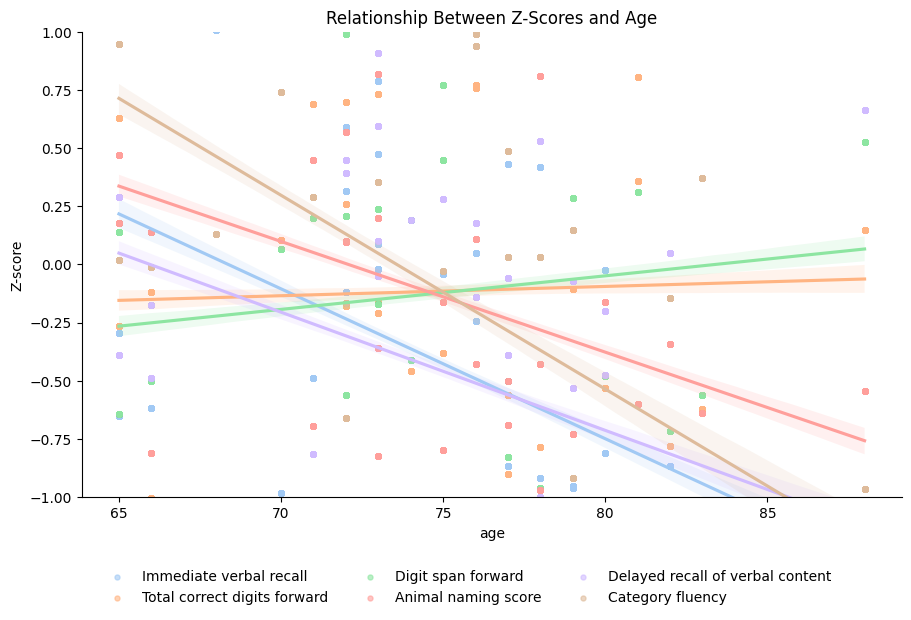

<Figure size 640x480 with 0 Axes>

In [23]:
# 3 Cognitive plot

# Variables and mapping to meaningful names
z_vars = [
    "craft_im_verb_z",
    "totcorrect_df_z", "dig_forward_tc_zscore",
    "an_z_score", "craft_delay_verb_z", "ant_z_score"
]

label_map = {
    "craft_im_verb_z": "Immediate verbal recall",
    "totcorrect_df_z": "Total correct digits forward",
    "dig_forward_tc_zscore": "Digit span forward",
    "an_z_score": "Animal naming score",
    "craft_delay_verb_z": "Delayed recall of verbal content",
    "ant_z_score": "Category fluency"
}

age_var = "age"

# Reshape & replace labels
df_long = df.melt(id_vars=age_var, value_vars=z_vars,
                  var_name="Cognitive Test", value_name="Z-score")
df_long["Cognitive Test"] = df_long["Cognitive Test"].replace(label_map)

# Pastel palette (one color per cognitive test)
pastel_palette = sns.color_palette("pastel", len(df_long["Cognitive Test"].unique()))

# Create lmplot with pastel colors
g = sns.lmplot(
    data=df_long, x=age_var, y="Z-score", hue="Cognitive Test",
    height=6, aspect=1.5,
    scatter_kws={'alpha': 0.6, 's': 13, 'marker': 'o'},  # semi-transparent dots
    palette=pastel_palette,
    legend=False
)

# Title & limits
g.set(title="Relationship Between Z-Scores and Age")
g.set(ylim=(-1, 1))

# Add legend at bottom with extra space
handles, labels = g.ax.get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    loc='lower center', ncol=3, frameon=False,
    bbox_to_anchor=(0.5, 0)
)

# Increase bottom margin to avoid overlap
plt.subplots_adjust(bottom=0.20)
plt.show()
plt.tight_layout()
plt.show()

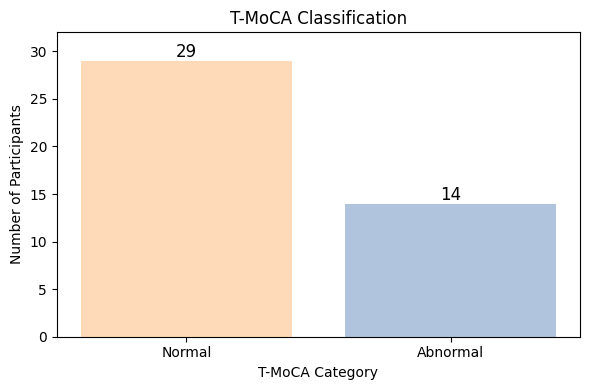

In [24]:
# 4 cognitive plot
tmoca_by_participant = df[["participant_id", "tmoca_rater_total"]].drop_duplicates(subset="participant_id")

# Categorize: Normal (≥ 18) vs. Abnormal (< 18)
tmoca_by_participant["tmoca_category"] = tmoca_by_participant["tmoca_rater_total"].apply(
    lambda x: "Normal" if pd.notnull(x) and x >= 18 else "Abnormal"
)

# Count how many participants fall into each category
counts = tmoca_by_participant["tmoca_category"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["#FFDAB9", "#B0C4DE"])  # pastel pink & blue
plt.title("T-MoCA Classification")
plt.xlabel("T-MoCA Category")
plt.ylabel("Number of Participants")

# Add count labels slightly below the top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
             ha='center', va='bottom', fontsize=12, color='black')

# Add some padding to the top of y-axis
plt.ylim(0, max(counts.values) + 3)

plt.tight_layout()
plt.show()


# Single participant view

In [25]:
# Filter using correct participant_id and date
target_date = "06/12/2023"
participant_row = df[(df['participant_id'] == 5) & (df['date'] == target_date)]

# Select relevant demographic columns
demographic_columns = ['participant_id', 'age', 'sex', 'education']
demographic_data = participant_row[demographic_columns] if not participant_row.empty else pd.DataFrame()

demographic_data


,participant_id,age,sex,education
13,5,66,1,16


In [26]:
# Filter data for Participant 5 on June 12, 2023
participant_data = df[(df["participant_id"] == 5) & (df["date"] == "2023-06-12")]

# Extract GPS-related columns
gps_columns = [col for col in df.columns if "gps" in col.lower() or "location" in col.lower() or "distance" in col.lower()]
gps_data = participant_data[gps_columns]

gps_data.T.sort_index()  # Display transposed for easier viewing


,13
distance_traveled,230.741602
location_entropy,0.391052
location_variance,-4.052478
max_distance_from_home,62.819735
max_pairwise_distance,62.819735
normalized_location_entropy,0.242975
shortWordCharKeyDownErrorDistance_5th,3.736000
shortWordCharKeyDownErrorDistance_95th,20.542000
shortWordCharKeyDownErrorDistance_mad,3.760000
shortWordCharKeyDownErrorDistance_mean,11.454383


In [27]:
avg_distance = df.loc[df['participant_id'] == 5, 'distance_traveled'].mean()
print(f"Average distance traveled per day: {avg_distance:.2f}")

Average distance traveled per day: 52.09


In [28]:
# If home_stay is in hours and the total day is 24 hours:
df_part5 = df[df['participant_id'] == 5]

df_part5['home_stay_percent'] = (df_part5['home_stay'] / 24) * 100

# Average percentage time at home
avg_home_stay_percent = df_part5['home_stay_percent'].mean()

print(f"Average percentage of time at home: {avg_home_stay_percent:.2f}%")

Average percentage of time at home: 72.69%


/var/folders/73/n4wwy86j3ms7q_z6xsy8_x1h0000gs/T/ipykernel_66868/395123131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part5['home_stay_percent'] = (df_part5['home_stay'] / 24) * 100


Participant 5 KPIs
- Avg Home Time: 84.9% (Away: 15.1%)
- Avg Distance/Day: 52.09
- Avg #Clusters/Day: 3.97
- Max Distance from Home: 62.82
- Typical First Movement: 8.80
- Avg Stationary vs Moving: 94.9% / 5.1%


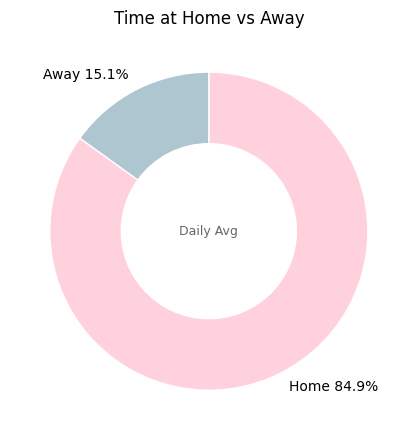

In [29]:
# Filter participant 5
pid = 5
df_p = df.loc[df['participant_id'] == pid].copy()

# Home vs Away %
# Prefer home_stay_proportion if present (0–1). Fallback: compute from hours (assumes 24h day).
if 'home_stay_proportion' in df_p.columns and np.isfinite(df_p['home_stay_proportion']).any():
    home_prop_daily = df_p['home_stay_proportion'].clip(0, 1)
else:
    # If 'home_stay' exists (in hours); adjust divisor if your unit is minutes (use 1440).
    if 'home_stay' in df_p.columns:
        home_prop_daily = (df_p['home_stay'] / 24).clip(0, 1)
    else:
        raise ValueError("Need either 'home_stay_proportion' (0–1) or 'home_stay' (hours).")

home_pct = float(home_prop_daily.mean() * 100.0)
away_pct = 100.0 - home_pct

# KPIs (averaged across days)
avg_distance = float(df_p['distance_traveled'].mean()) if 'distance_traveled' in df_p else np.nan
avg_clusters = float(df_p['num_cluster'].mean()) if 'num_cluster' in df_p else np.nan
max_from_home = float(df_p['max_distance_from_home'].max()) if 'max_distance_from_home' in df_p else np.nan

# First movement time: if minutes-from-midnight, convert to HH:MM; otherwise just show mean raw
if 'first_movement_time' in df_p:
    fm = df_p['first_movement_time'].dropna()
    if len(fm) and fm.max() > 24:  # likely minutes
        fm_minutes = float(fm.mean())
        fm_h = int(fm_minutes // 60)
        fm_m = int(round(fm_minutes % 60))
        first_move_str = f"{fm_h:02d}:{fm_m:02d}"
    else:
        first_move_str = f"{float(fm.mean()):.2f}"
else:
    first_move_str = "N/A"

# Stationary vs Moving % (averaged per-day ratio, safer than global sum)
if {'stationary_time','moving_time'}.issubset(df_p.columns):
    denom = (df_p['stationary_time'] + df_p['moving_time']).replace(0, np.nan)
    stationary_pct = float((df_p['stationary_time'] / denom).mean() * 100.0)
    moving_pct = 100.0 - stationary_pct
else:
    stationary_pct = moving_pct = np.nan

# Print KPIs (text)
print(f"Participant {pid} KPIs")
print(f"- Avg Home Time: {home_pct:.1f}% (Away: {away_pct:.1f}%)")
print(f"- Avg Distance/Day: {avg_distance:.2f}")
print(f"- Avg #Clusters/Day: {avg_clusters:.2f}")
print(f"- Max Distance from Home: {max_from_home:.2f}")
print(f"- Typical First Movement: {first_move_str}")
if np.isfinite(stationary_pct):
    print(f"- Avg Stationary vs Moving: {stationary_pct:.1f}% / {moving_pct:.1f}%")

# Donut plot: Home vs Away
fig, ax = plt.subplots(figsize=(4.5, 4.5))
vals = [home_pct, away_pct]
labels = [f"Home {home_pct:.1f}%", f"Away {away_pct:.1f}%"]
colors = ['#FFD1DC', '#AEC6CF']  # pastel pink, pastel blue

wedges, _ = ax.pie(
    vals,
    labels=labels,
    colors=colors,
    startangle=90,
    counterclock=False,
    wedgeprops={'width': 0.45, 'edgecolor': 'white'}
)
ax.set_title(f"Time at Home vs Away")
# Center text
ax.text(0, 0, "Daily Avg", ha='center', va='center', fontsize=9, color="#666")

plt.tight_layout()
plt.show()


In [30]:
pid = 5
df_p5 = df[df['participant_id'] == pid].copy()

# Max distance from home (and the day it occurred)
if 'max_distance_from_home' in df_p5.columns:
    idx = df_p5['max_distance_from_home'].idxmax()
    max_from_home = float(df_p5.loc[idx, 'max_distance_from_home'])
    max_from_home_date = pd.to_datetime(df_p5.loc[idx, 'date']).date()
    print(f"Max distance from home (participant {pid}): {max_from_home:.2f} on {max_from_home_date}")
else:
    print("Column 'max_distance_from_home' not found.")

# Max pairwise distance (and the day it occurred)
if 'max_pairwise_distance' in df_p5.columns:
    idx2 = df_p5['max_pairwise_distance'].idxmax()
    max_pairwise = float(df_p5.loc[idx2, 'max_pairwise_distance'])
    max_pairwise_date = pd.to_datetime(df_p5.loc[idx2, 'date']).date()
    print(f"Max pairwise distance (participant {pid}): {max_pairwise:.2f} on {max_pairwise_date}")
else:
    print("Column 'max_pairwise_distance' not found.")


Max distance from home (participant 5): 62.82 on 2023-06-12
Max pairwise distance (participant 5): 62.82 on 2023-06-12


In [31]:
# Total cluster stay for participant 5
participant_id = 5

total_cluster_stay_p5 = df[df["participant_id"] == participant_id]["total_cluster_stay"].mean()

print(f"Total cluster stay for participant {participant_id}: {total_cluster_stay_p5:.2f} hours")


Total cluster stay for participant 5: 20.56 hours


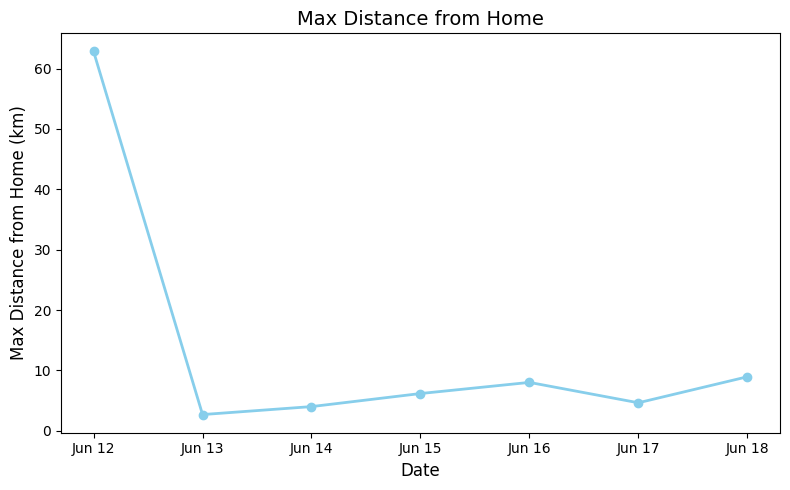

In [32]:
# Filter for participant 5 and date range
participant_id = 5
start_date = "2023-06-12"
end_date = "2023-06-18"

df_filtered = df[
    (df["participant_id"] == participant_id) &
    (df["date"] >= start_date) &
    (df["date"] <= end_date)
].copy()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    df_filtered["date"], 
    df_filtered["max_distance_from_home"], 
    marker='o', 
    markersize=6, 
    color="#87CEEB",  # pastel blue
    linewidth=2
)

# Formatting
plt.title(f"Max Distance from Home", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Max Distance from Home (km)", fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.tight_layout()

plt.show()


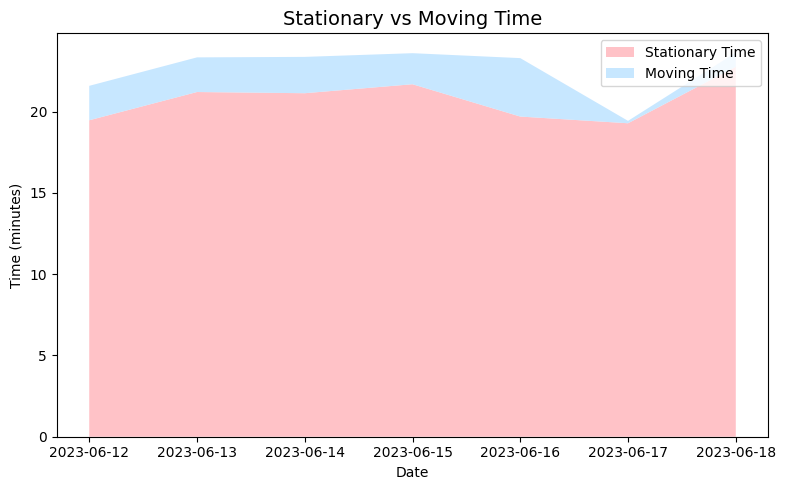

In [33]:
# Filter for participant 5 and date range
week_data = df[
    (df["participant_id"] == 5) &
    (df["date"] >= "2023-06-12") &
    (df["date"] <= "2023-06-18")
]

# Ensure date is sorted
week_data = week_data.sort_values("date")

# Create area plot
plt.figure(figsize=(8, 5))
plt.stackplot(
    week_data["date"],
    week_data["stationary_time"],
    week_data["moving_time"],
    labels=["Stationary Time", "Moving Time"],
    colors=["#FFB3BA", "#BAE1FF"],  # pastel pink, pastel blue
    alpha=0.8
)

# Labels & title
plt.title("Stationary vs Moving Time", fontsize=14)
plt.ylabel("Time (minutes)")
plt.xlabel("Date")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


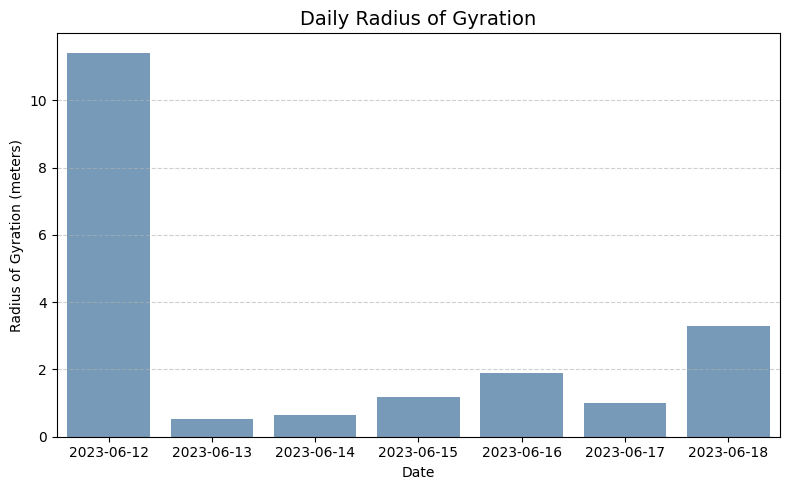

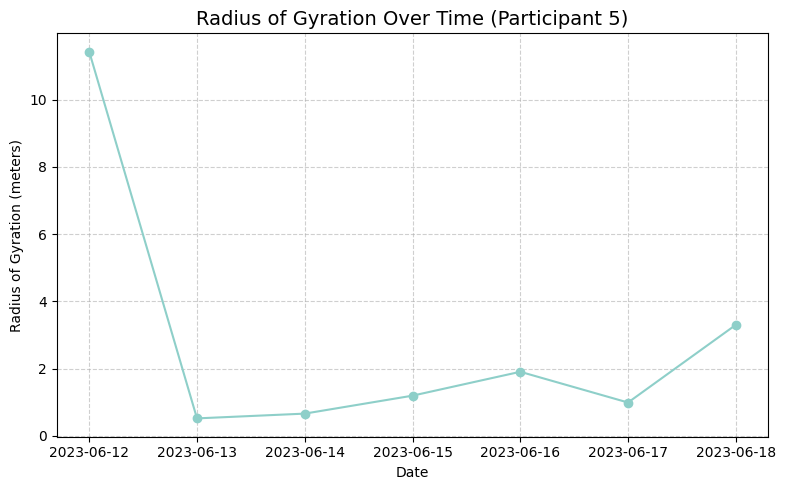

In [34]:

p5_data = df[
    (df["participant_id"] == 5) &
    (df["date"] >= "2023-06-12") &
    (df["date"] <= "2023-06-18")
]
plt.figure(figsize=(8, 5))
sns.barplot(data=p5_data, x="date", y="radius_of_gyration", color= 'steelblue', alpha = 0.8)
plt.title("Daily Radius of Gyration", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Radius of Gyration (meters)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(p5_data["date"], p5_data["radius_of_gyration"], marker="o", color="#8ECFC9")
plt.title("Radius of Gyration Over Time (Participant 5)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Radius of Gyration (meters)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


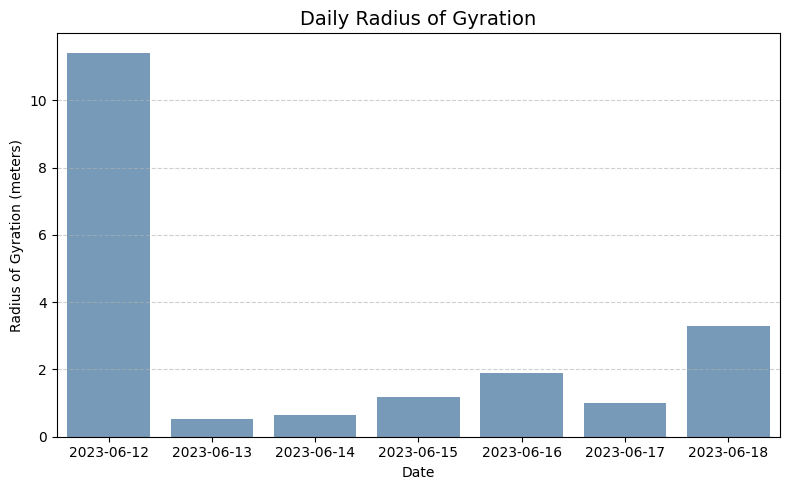

In [35]:

p5_data = df[
    (df["participant_id"] == 5) &
    (df["date"] >= "2023-06-12") &
    (df["date"] <= "2023-06-18")
]
plt.figure(figsize=(8, 5))
sns.barplot(data=p5_data, x="date", y="radius_of_gyration", color= 'steelblue', alpha = 0.8)
plt.title("Daily Radius of Gyration", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Radius of Gyration (meters)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# # Plot
# plt.figure(figsize=(8, 5))
# plt.plot(p5_data["date"], p5_data["radius_of_gyration"], marker="o", color="#8ECFC9")
# plt.title("Radius of Gyration Over Time (Participant 5)", fontsize=14)
# plt.xlabel("Date")
# plt.ylabel("Radius of Gyration (meters)")
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.tight_layout()
# plt.show()


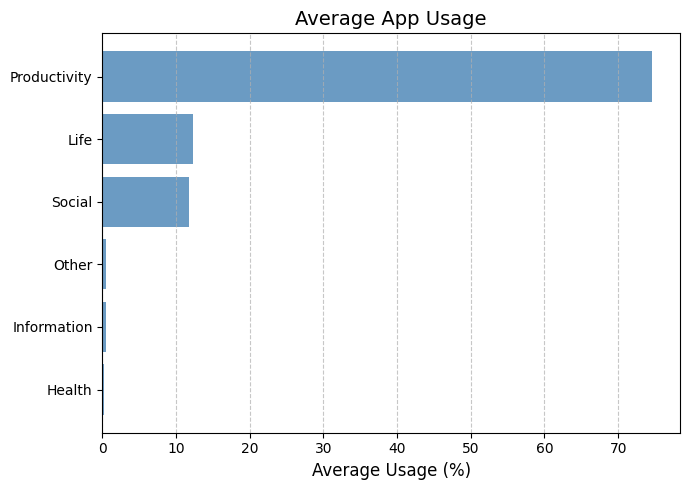

In [36]:
# Filter for Participant 5
participant_id = 5
df_p5 = df[df["participant_id"] == participant_id].copy()

# App usage proportion variables
app_vars = [
    "information_app_usage_proportion",
    "productivity_app_usage_proportion",
    "life_app_usage_proportion",
    "health_app_usage_proportion",
    "social_app_usage_proportion",
    "other_app_usage_proportion"
]

# Calculate average percentages
app_avgs = df_p5[app_vars].mean() * 100  # Convert to percentage
app_avgs.index = [label.replace("_app_usage_proportion", "").capitalize() for label in app_vars]

# Sort in descending order
app_avgs = app_avgs.sort_values(ascending=False)

# Horizontal bar plot
plt.figure(figsize=(7, 5))
plt.barh(app_avgs.index, app_avgs, color= 'steelblue', alpha = 0.8)
plt.xlabel("Average Usage (%)", fontsize=12)
plt.title("Average App Usage", fontsize=14)
plt.gca().invert_yaxis()  # Highest percentage at top
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [37]:
# Participant filter
participant_id = 5
df_p5 = df[df["participant_id"] == participant_id].copy()

# Variables to extract
kpi_vars = [
    "total_unlocks",
    "total_unlock_duration",
    "total_words",
    "incoming_call",
    "incoming_msg",
    "outgoing_call",
    "outgoing_msg",
    "call_duration"
]

# Calculate averages
kpi_avgs = df_p5[kpi_vars].mean().round(2)

# Convert to dataframe for easy viewing
kpi_df = pd.DataFrame({
    "Metric": kpi_avgs.index,
    "Average": kpi_avgs.values
})

print(kpi_df)


                  Metric  Average
0          total_unlocks    47.59
1  total_unlock_duration  7944.13
2            total_words   195.86
3          incoming_call     4.04
4           incoming_msg    37.21
5          outgoing_call     4.64
6           outgoing_msg    20.28
7          call_duration  1354.37


In [38]:
pid = 5
p = df[df["participant_id"] == pid].copy()

# Helper: pick Health if available, else Pedometer
def pick_col(preferred, fallback):
    if preferred in p.columns and p[preferred].notna().any():
        return preferred
    return fallback

# Columns to use
steps_col   = pick_col("step_count_health", "step_count_pedo")
dist_col    = pick_col("walking_distance_health", "walking_distance_pedo")
walk_dur    = "walking_duration"
run_dur     = "running_duration"
speed_avg   = "walking_speed_avg"
step_len    = "walking_step_length_avg"
cadence     = "walking_segments_cadence_mean"
asym_avg    = "walking_asymmetry_avg"
dsupport    = "double_support_time_avg"

# Compute KPIs (per-day averages, since each row is a day)
kpis = {
    "Daily Steps (avg)":                     p[steps_col].mean() if steps_col in p else np.nan,
    "Walking Distance / day (avg)":         p[dist_col].mean() if dist_col in p else np.nan,
    "Walking Duration / day (min, avg)":    p[walk_dur].mean() if walk_dur in p else np.nan,
    "Running Duration / day (min, avg)":    p[run_dur].mean() if run_dur in p else np.nan,
    "Walking Speed (m/s, avg)":             p[speed_avg].mean() if speed_avg in p else np.nan,
    "Step Length (avg)":                    p[step_len].mean() if step_len in p else np.nan,
    "Cadence (steps/min, avg)":             p[cadence].mean() if cadence in p else np.nan,
    "Walking Asymmetry (%, avg)":           p[asym_avg].mean() if asym_avg in p else np.nan,
    "Double Support Time (%, avg)":         p[dsupport].mean() if dsupport in p else np.nan,
}

kpi_df = pd.DataFrame.from_dict(kpis, orient="index", columns=["Participant 5"])
print(kpi_df.round(2))


                                   Participant 5
Daily Steps (avg)                        2443.82
Walking Distance / day (avg)                1.01
Walking Duration / day (min, avg)           0.38
Running Duration / day (min, avg)           0.00
Walking Speed (m/s, avg)                    2.08
Step Length (avg)                          22.11
Cadence (steps/min, avg)                    1.48
Walking Asymmetry (%, avg)                  0.10
Double Support Time (%, avg)                0.33


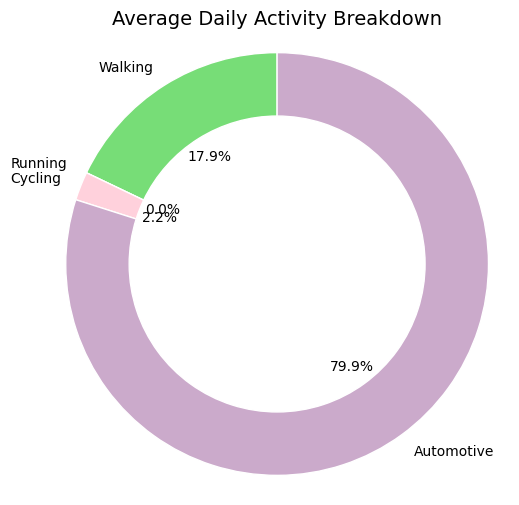

In [39]:
# Filter data for participant 5
participant_id = 5
df_p5 = df[df["participant_id"] == participant_id]

# Select the columns for activity durations (assuming they are in minutes or seconds)
activity_vars = ["walking_duration", "running_duration", "cycling_duration", "automotive_duration"]

# Calculate average daily duration for each activity
activity_avgs = df_p5[activity_vars].mean()

# Colors (pastel)
colors = ["#77DD77", "#FFB347", "#FFD1DC", "#CBAACB"]

# Plot donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    activity_avgs,
    labels=[label.replace("_duration", "").capitalize() for label in activity_vars],
    autopct="%.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.3, edgecolor="white")
)

# Equal aspect ratio ensures the pie is circular
ax.axis("equal")
plt.title(f"Average Daily Activity Breakdown", fontsize=14)
plt.show()


/var/folders/73/n4wwy86j3ms7q_z6xsy8_x1h0000gs/T/ipykernel_66868/2878117868.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p5_week["walking_duration_minutes"] = df_p5_week["walking_duration"] * 60


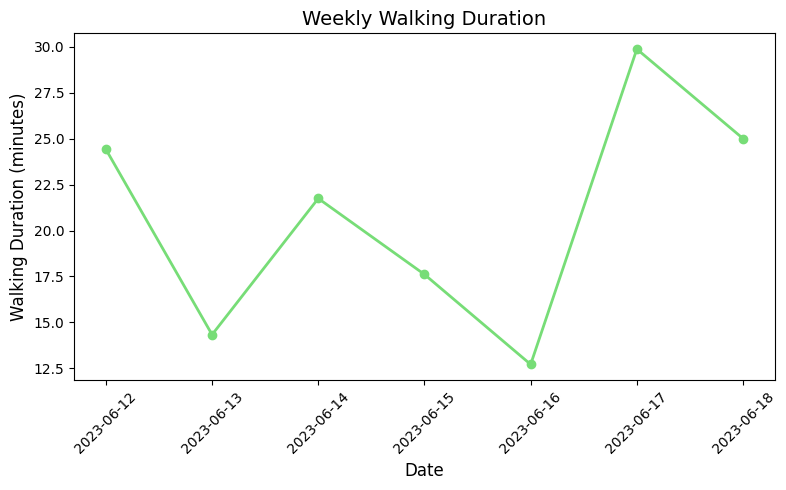

In [40]:

participant_id = 5
start_date = "2023-06-12"
end_date = "2023-06-18"

df["date"] = pd.to_datetime(df["date"])
df_p5_week = df[
    (df["participant_id"] == participant_id) &
    (df["date"] >= start_date) &
    (df["date"] <= end_date)
]
# Convert walking_duration to minutes if it's in hours or seconds
# If in hours:
df_p5_week["walking_duration_minutes"] = df_p5_week["walking_duration"] * 60


# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_p5_week["date"], df_p5_week["walking_duration_minutes"], marker='o', color="#77DD77", linewidth=2)

plt.title("Weekly Walking Duration", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Walking Duration (minutes)", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


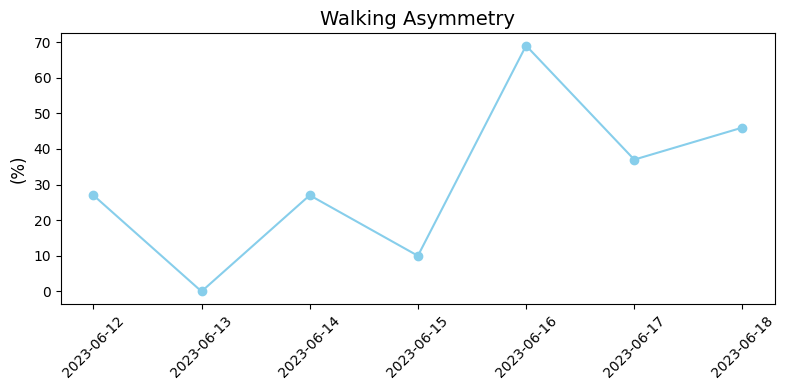

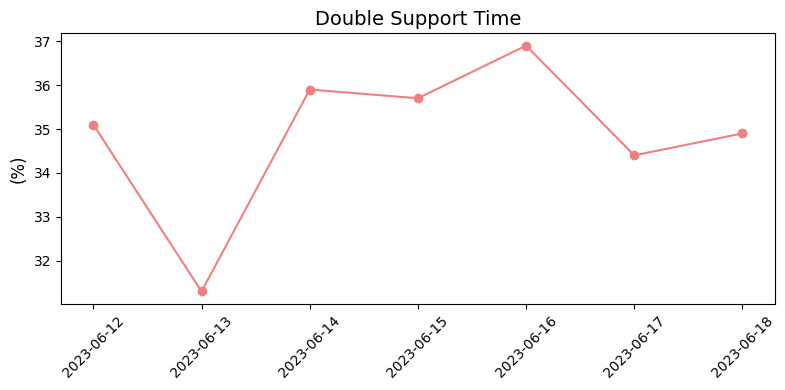

In [41]:
# Filter data for participant 5 and the week of June 12–18, 2023
week_data = df[
    (df["participant_id"] == 5) &
    (df["date"] >= "2023-06-12") &
    (df["date"] <= "2023-06-18")
].copy()

# Convert to percentages
week_data["walking_asymmetry_max_pct"] = week_data["walking_asymmetry_max"] * 100
week_data["double_support_time_max_pct"] = week_data["double_support_time_max"] * 100

# Plot 1: Walking Asymmetry Max
plt.figure(figsize=(8, 4))
plt.plot(
    week_data["date"], week_data["walking_asymmetry_max_pct"],
    marker='o', linestyle='-', color='skyblue', label="Max Walking Asymmetry"
)
plt.ylabel("(%)", fontsize=12)
plt.title("Walking Asymmetry", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Double Support Time Max
plt.figure(figsize=(8, 4))
plt.plot(
    week_data["date"], week_data["double_support_time_max_pct"],
    marker='o', linestyle='-', color='lightcoral', label="Max Double Support Time"
)
plt.ylabel("(%)", fontsize=12)
plt.title("Double Support Time", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


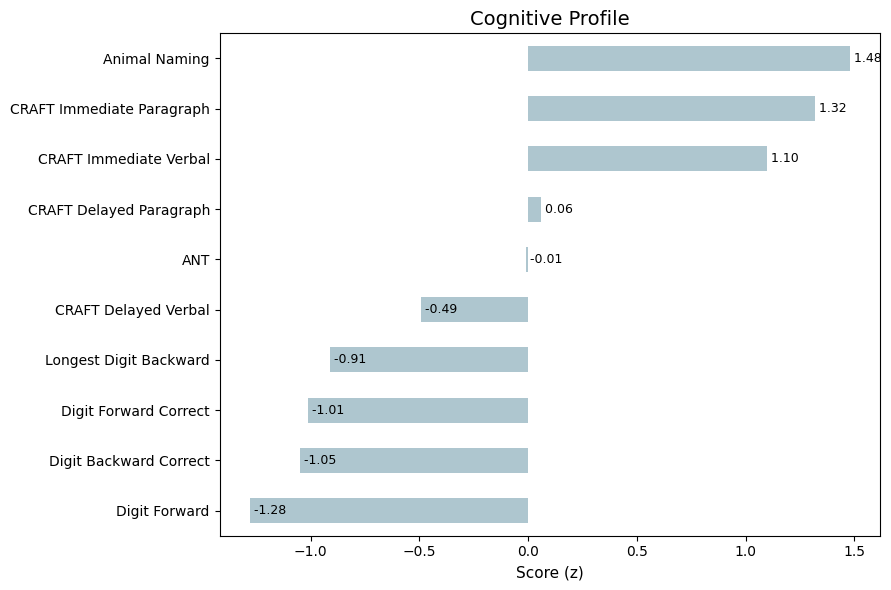

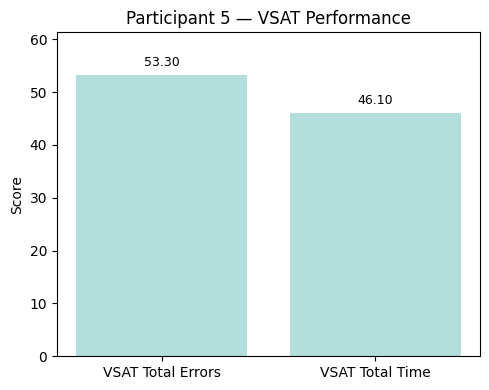

In [42]:
# Config
pid = 5

# Variables
cog_vars_main = [
    "craft_im_verb_z","craft_im_para_z","totcorrect_df_z",
    "dig_forward_tc_zscore","totcorrect_db_z","br_longestdigb_z","an_z_score",
    "craft_delay_verb_z","craft_delay_para_z","ant_z_score"
]

# df["true_vsat_time_z"] = (df["vsat_total_time_z"] - 50) / 10
# df["true_vsat_errors_z"] = (df["vsat_total_errors_z"] - 50) / 10

vsat_vars = ["vsat_total_time_z","vsat_total_errors_z"]

# Nice labels
label_map_main = {
    "craft_im_verb_z": "CRAFT Immediate Verbal",
    "craft_im_para_z": "CRAFT Immediate Paragraph",
    "totcorrect_df_z": "Digit Forward Correct",
    "dig_forward_tc_zscore": "Digit Forward",
    "totcorrect_db_z": "Digit Backward Correct",
    "br_longestdigb_z": "Longest Digit Backward",
    "an_z_score": "Animal Naming",
    "craft_delay_verb_z": "CRAFT Delayed Verbal",
    "craft_delay_para_z": "CRAFT Delayed Paragraph",
    "ant_z_score": "ANT"
}
label_map_vsat = {
    "vsat_total_time_z": "VSAT Total Time",
    "vsat_total_errors_z": "VSAT Total Errors"
}

# Filter participant row (assumes exactly one row for pid)
row = df.loc[df["participant_id"] == pid].iloc[0]

# Build series for plotting 
main_values = pd.Series({label_map_main[k]: row[k] for k in cog_vars_main if k in row.index})
vsat_values  = pd.Series({label_map_vsat[k]: row[k] for k in vsat_vars if k in row.index})

# Plot main cognitive measures (horizontal bar)
plt.figure(figsize=(9, 6))
main_values.sort_values(ascending=False).plot(kind="barh", color="#AEC6CF")
plt.gca().invert_yaxis()
plt.xlabel("Score (z)", fontsize=11)
plt.title(f"Cognitive Profile", fontsize=14)

# annotate
for i, v in enumerate(main_values.sort_values(ascending=False).values):
    plt.text(v, i, f" {v:.2f}", va="center", ha="left", fontsize=9)
plt.tight_layout()
plt.show()

# VSAT Vertical Bar Plot
plt.figure(figsize=(5, 4))
vsat_sorted = vsat_values.sort_values(ascending=False)

bars = plt.bar(vsat_sorted.index, vsat_sorted.values, color="#B2DFDB")
plt.ylabel("Score", fontsize=10)
plt.title(f"Participant {pid} — VSAT Performance", fontsize=12)

# Add padding to y-limit
max_val = vsat_sorted.max()
plt.ylim(0, max_val * 1.15)  # 15% extra space

# Annotate values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + (max_val * 0.02),
             f"{height:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


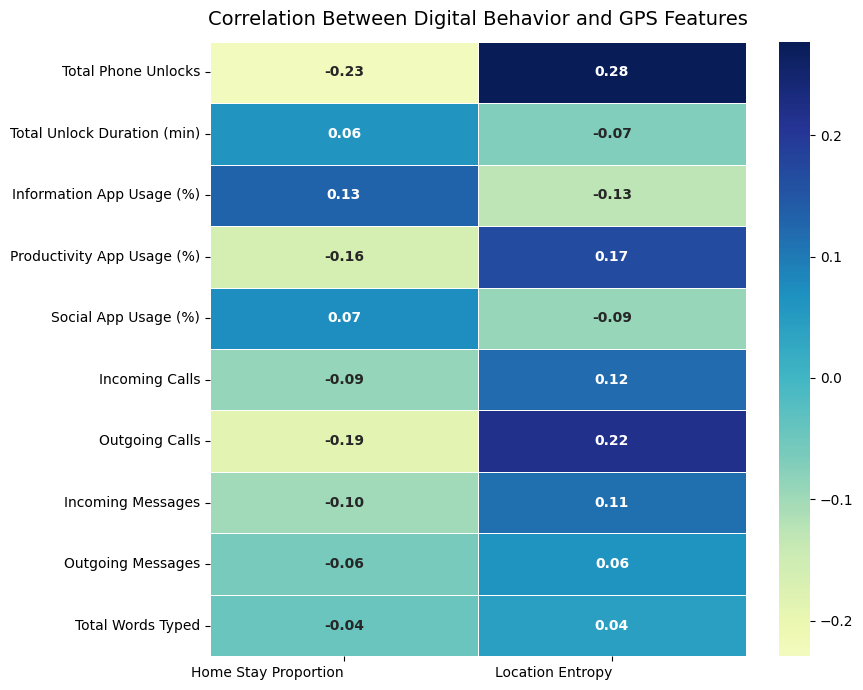

In [43]:
# Define mappings
var_map = {
    "total_unlocks": "Total Phone Unlocks",
    "total_unlock_duration": "Total Unlock Duration (min)",
    "information_app_usage_proportion": "Information App Usage (%)",
    "productivity_app_usage_proportion": "Productivity App Usage (%)",
    "social_app_usage_proportion": "Social App Usage (%)",
    "incoming_call": "Incoming Calls",
    "outgoing_call": "Outgoing Calls",
    "incoming_msg": "Incoming Messages",
    "outgoing_msg": "Outgoing Messages",
    "total_words": "Total Words Typed",
    "home_stay_proportion": "Home Stay Proportion",
    "location_entropy": "Location Entropy"
}

# Variables
digital_vars = list(var_map.keys())[:-2]
gps_vars = ["home_stay_proportion", "location_entropy"]

# Subset and drop missing
cols = digital_vars + gps_vars
df_subset = df[cols].dropna()

# Compute correlations
corr = df_subset.corr()
corr_focus = corr.loc[digital_vars, gps_vars]

# Rename columns/rows for better readability
corr_focus.rename(index=var_map, columns=var_map, inplace=True)

# Plot heatmap
plt.figure(figsize=(9,7))
sns.heatmap(
    corr_focus,
    annot=True,
    cmap='YlGnBu',  # blue-white-red
    center=0,
    linewidths=0.5,
    fmt=".2f",
    annot_kws={"size": 10, "weight": "bold"}
)
plt.title("Correlation Between Digital Behavior and GPS Features", fontsize=14, pad=12)
plt.xticks(rotation=0, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()
